# **Case study 1 - Predictive maintenance of machine failure**

## **1.Business Problem**

### **1.1 Description**
Sources : https://www.kaggle.com/yuansaijie0604/xinjiang-pm

Problem Statement: 

The business problem for this example is about predicting problems caused by component failures such that the question "What is the probability that a machine will fail in the near future due to a failure of a certain component?" can be answered.



### **1.2 Overview of the Problem**

Predictive maintenance for industry 4.0 is a method of preventing asset failure by analyzing production data to identify patterns and predict issues before they happen. It is not a surprise therefore, that predictive maintenance has quickly emerged as a leading Industry 4.0 use case for manufacturers and asset managers. Implementing industrial IoT technologies to monitor asset health, optimize maintenance schedules, and gaining real-time alerts to operational risks, allows manufacturers to lower service costs, maximize uptime,
and improve production throughput.

A major problem faced by businesses in asset-heavy industries such as manufacturing is the significant costs that are associated with delays in the production process due to mechanical problems. Most of these businesses are interested in predicting these problems in advance so that they can proactively prevent the problems before they occur which will reduce the costly impact caused by downtime.

### **1.3 Real-world/Business objectives and constraints:**

1.   Interpretability is important.
2.   Errors can be very costly.
3.   Probability of a data-point belonging to each class is needed.


# **2. Machine Learning Problem Formulation**
## **2.1. Data**
### **2.1.1. Data Overview**

*   Source: https://www.kaggle.com/yuansaijie0604/xinjiang-pm
*   We have five data files: failure history, maintenance history, machine conditions in usuage, machine features, and operators features.

Common data sources for predictive maintenance problems are :

**Failure history:** The failure history of a machine or component within the machine.

**Maintenance history:** The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.

**Machine conditions and usage:** The operating conditions of a machine e.g. data collected from sensors.

**Machine features:** The features of a machine, e.g. engine size, make and model, location.

**Operator features:** The features of the operator, e.g. gender, past experience The data for this example comes from 4 different sources which are real-time telemetry data collected from machines, error messages, historical maintenance records that include failures and machine information such as type and age.

## **2.2 Mapping the real-world problem to an ML problem**

### **2.2.1 Types of Machine learning problem**

Multi-class classification / multi label classification problem

### **2.2.2. Performance Metric**

1) Confusion matrix
2) Classification report(Accuracy, Precision, Recall, F1-score)

### **2.2.3. Machine Learing Objectives and Constraints**

Objective: "What is the probability that a machine will fail in the near future due to a failure of a certain component?" 
Constraints:

a) Class probabilities are needed.

b) Penalize the errors in class probabilites => Metric is F1-score.

c) No Latency constraints.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Importing the libraries**

Let's import some libraries to get started!

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import scipy.stats as st
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **1) Reading the data**

Let's start by reading csv file into a pandas dataframe.

In [3]:
telemetry = pd.read_csv("/content/drive/My Drive/PdM data/PdM_telemetry.csv", error_bad_lines=False)

# **2) Data cleaning and Expolratory Data Analysis**

Let's begin some exploratory data analysis on the data!

### **2.1) Telemetry data**

The first data source is the telemetry time-series data which consists of voltage, rotation, pressure, and vibration measurements collected from 100 machines in real time averaged over every hour collected during the year 2015. Below, we display the first 10 records in the dataset. A summary of the whole dataset is also provided.

In [4]:
print('Number of data points in the telemetry data', telemetry.shape)
print('-'*127)
print('The attributes of the data points in the telemetry data :', telemetry.columns.values)
telemetry.head(5)

Number of data points in the telemetry data (876100, 6)
-------------------------------------------------------------------------------------------------------------------------------
The attributes of the data points in the telemetry data : ['datetime' 'machineID' 'volt' 'rotate' 'pressure' 'vibration']


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


Let us examine numerical features in the telemetry.

In [5]:
telemetry_num_feat = telemetry.select_dtypes(include=[np.number])  # Return a subset of the DataFrame's columns based on the column dtypes.
telemetry_num_feat.columns

Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration'], dtype='object')

Let us examine categorical features in the telemetry.

In [6]:
telemetry_cat_feat = telemetry.select_dtypes(include=[np.object]) # Return a subset of the DataFrame's columns based on the column dtypes.
telemetry_cat_feat.columns

Index(['datetime'], dtype='object')

From this above observation, we are going to conclude that machineID, volt, rotate, pressure and vibration are numerical features and datetime is a categorical feature.

In [7]:
#ref: https://stackoverflow.com/questions/22470690/get-list-of-pandas-dataframe-columns-based-on-data-type
data_types = telemetry.columns.to_series().groupby(telemetry.dtypes).groups
data_types

{dtype('int64'): Index(['machineID'], dtype='object'),
 dtype('float64'): Index(['volt', 'rotate', 'pressure', 'vibration'], dtype='object'),
 dtype('O'): Index(['datetime'], dtype='object')}

In [8]:
datatype = telemetry.dtypes.reset_index()
datatype.columns = ["Count", "Column Type"]
datatype.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,1
1,float64,4
2,object,1


As we can observe, there is one int64 columns corresponding to machineID, 4 columns are corresponding to float64 column are target variable.

In [9]:
telemetry["machineID"].nunique() # return number of unique elements in the object

100

In [10]:
print("Number of duplicate values in telemetry data is "+str(sum(telemetry.duplicated())))

Number of duplicate values in telemetry data is 0


In [11]:
# We change the datetime format since it comes as a string.
# https://stackoverflow.com/questions/38067704/how-to-change-the-datetime-format-in-pandas
telemetry["datetime"] = pd.to_datetime(telemetry["datetime"], format="%Y-%m-%d %H:%M:%S")
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


One of the most elementary steps to do this is by getting a basic description of your data. We can use the describe() function to get various summary statistics that exclude NaN values.

In [12]:
# We confirm integrity; totals, average, standard deviation, minimum, maximum, and quantiles.
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


**Missing data**

Let's check for missing values if any our data. We can use seaborn to create a simple heatmap to see where we are missing!

In [13]:
telemetry.isnull()

,datetime,machineID,volt,rotate,pressure,vibration
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
876095,False,False,False,False,False,False
876096,False,False,False,False,False,False
876097,False,False,False,False,False,False
876098,False,False,False,False,False,False



Graphical representation of null values for telemetry data



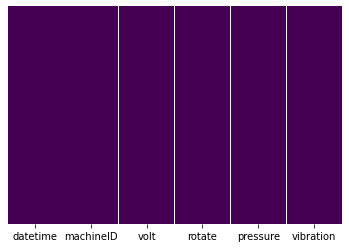

In [14]:
print("\nGraphical representation of null values for telemetry data\n")
sns.heatmap(telemetry.isnull(),yticklabels=False,cbar=False,cmap='viridis')

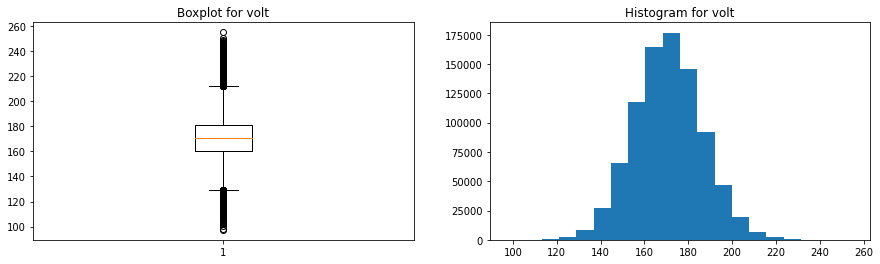

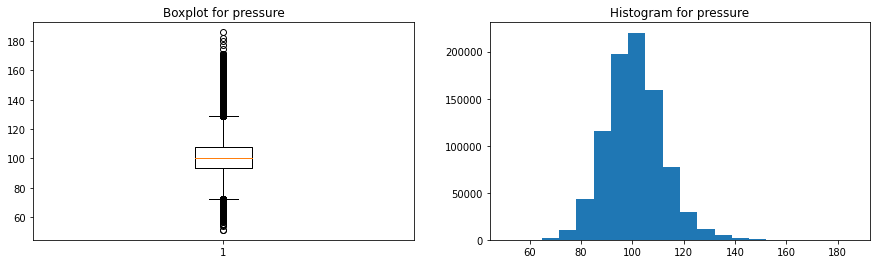

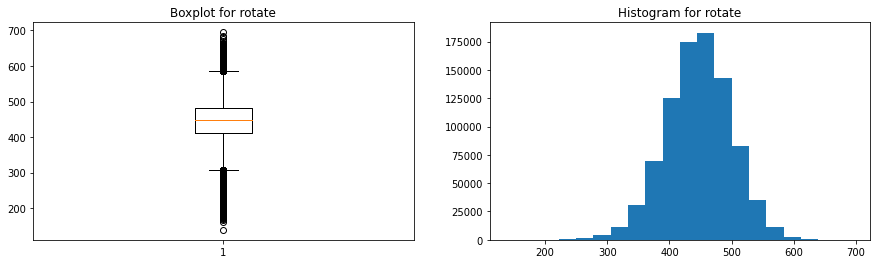

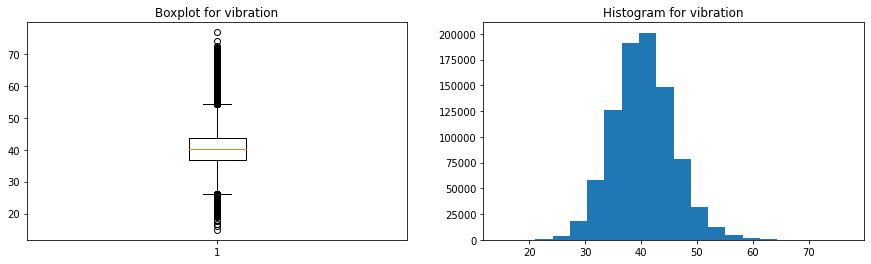

In [15]:
for feature in ['volt','pressure','rotate', 'vibration']:

    # Creating an empty chart
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

    # Extracting the feature values
    x = telemetry[feature].values

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title( 'Boxplot for {}'.format(feature) )

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title( 'Histogram for {}'.format(feature) )

    # Display
    plt.show()

we have a pretty standard distribution here, which is centred around almost exactly 100 and 40 in the histogram of pressure and vibration.

In [16]:
# Now that the Date column is the correct data type, let’s set it as the DataFrame’s index.
telemetry_daily = telemetry.set_index('datetime')
telemetry_daily.index

DatetimeIndex(['2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               '2015-01-01 10:00:00', '2015-01-01 11:00:00',
               '2015-01-01 12:00:00', '2015-01-01 13:00:00',
               '2015-01-01 14:00:00', '2015-01-01 15:00:00',
               ...
               '2015-12-31 21:00:00', '2015-12-31 22:00:00',
               '2015-12-31 23:00:00', '2016-01-01 00:00:00',
               '2016-01-01 01:00:00', '2016-01-01 02:00:00',
               '2016-01-01 03:00:00', '2016-01-01 04:00:00',
               '2016-01-01 05:00:00', '2016-01-01 06:00:00'],
              dtype='datetime64[ns]', name='datetime', length=876100, freq=None)

In [17]:
# Add columns with year, month, and weekday name
telemetry_daily['Year'] = telemetry_daily.index.year
telemetry_daily['Month'] = telemetry_daily.index.month
# Display a random sampling of 5 rows
telemetry_daily.sample(5, random_state=0)

,machineID,volt,rotate,pressure,vibration,Year,Month
datetime,,,,,,,
2015-11-10 10:00:00,12,183.474543,401.611420,113.651056,33.861788,2015,11
2015-04-05 01:00:00,11,183.698983,431.136255,113.975554,41.374202,2015,4
2015-05-23 19:00:00,7,165.814068,347.366614,96.854242,44.078230,2015,5
2015-03-22 07:00:00,91,186.737602,472.791264,93.310759,43.738045,2015,3
2015-09-28 22:00:00,2,164.454460,428.819420,104.138994,39.566097,2015,9


In [18]:
telemetry_daily.loc['2015-01-01']

,machineID,volt,rotate,pressure,vibration,Year,Month
datetime,,,,,,,
2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2015,1
2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,2015,1
2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,2015,1
2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,2015,1
2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,2015,1
...,...,...,...,...,...,...,...
2015-01-01 19:00:00,100,152.838062,523.037935,82.391069,36.299877,2015,1
2015-01-01 20:00:00,100,180.789389,460.206249,95.805911,51.560264,2015,1
2015-01-01 21:00:00,100,169.935194,499.427772,96.412562,40.304575,2015,1


In [19]:
telemetry_daily.loc['2015-02-01':'2015-03-01']

,machineID,volt,rotate,pressure,vibration,Year,Month
datetime,,,,,,,
2015-02-01 00:00:00,1,161.366805,354.403540,87.529260,40.679471,2015,2
2015-02-01 01:00:00,1,168.840187,501.326976,95.896965,39.724321,2015,2
2015-02-01 02:00:00,1,145.581202,425.328660,101.703525,44.824130,2015,2
2015-02-01 03:00:00,1,171.948847,430.039942,112.137024,36.585952,2015,2
2015-02-01 04:00:00,1,163.614903,441.758062,106.058170,40.252144,2015,2
...,...,...,...,...,...,...,...
2015-03-01 19:00:00,100,167.152025,327.232632,103.024317,42.951839,2015,3
2015-03-01 20:00:00,100,182.614397,423.719602,107.196716,36.416024,2015,3
2015-03-01 21:00:00,100,187.025132,411.723919,93.306789,37.560995,2015,3


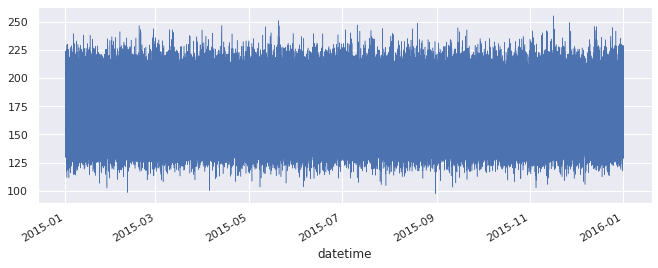

In [20]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
telemetry_daily['volt'].plot(linewidth=0.5);

This is the plot as an example for voltage values for machines for  the complete year of 2015 where the volt values tend to variate on all the four machines.

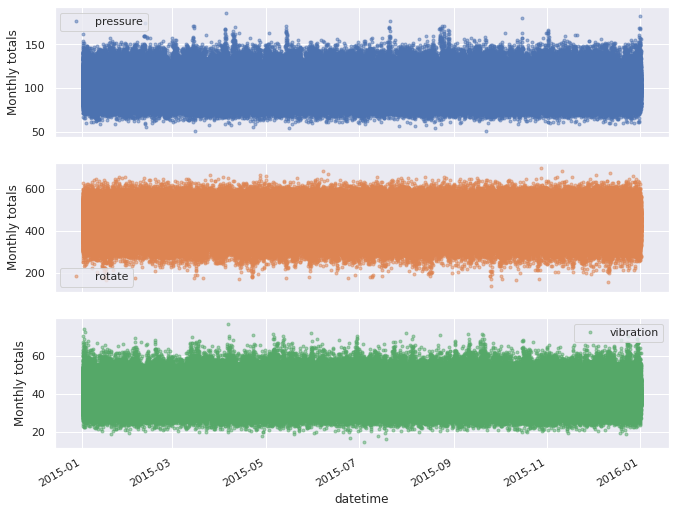

In [21]:
data_columns = ['pressure', 'rotate', 'vibration']
axes = telemetry_daily[data_columns].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Monthly totals')

## **2.2) Errors:**
The second main data source is the error logs. These are incessant errors that occur while the machine is still in operation and are not errors. The date and time of the error are rounded to the nearest hour, since telemetry data is collected every hour.

In [22]:
errors = pd.read_csv("/content/drive/My Drive/PdM data/PdM_errors.csv", error_bad_lines=False)

In [23]:
print('Number of data points in the errors data', errors.shape)
print('-'*127)
print('The attributes of the data points in the errors data :', errors.columns.values)
errors.head(5)

Number of data points in the errors data (3919, 3)
-------------------------------------------------------------------------------------------------------------------------------
The attributes of the data points in the errors data : ['datetime' 'machineID' 'errorID']


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [24]:
# format of datetime field which comes in as string
errors['datetime'] = pd.to_datetime(errors['datetime'],format = '%Y-%m-%d %H:%M:%S')

In [25]:
errors['errorID'] = errors['errorID'].astype('category')
print("Total Number of error records: %d" %len(errors.index))
errors.head()

Total Number of error records: 3919


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [26]:
errors["machineID"].nunique() # return number of unique elements in the object

100

In [27]:
errors.describe()

,machineID
count,3919.000000
mean,51.044654
std,28.954988
min,1.000000
25%,25.000000
50%,51.000000
75%,77.000000
max,100.000000



Graphical representation of null values for errors data



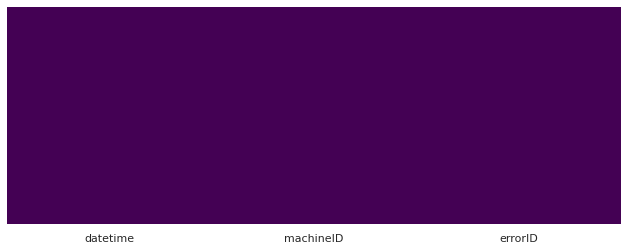

In [28]:
# Missing values in the errors
print("\nGraphical representation of null values for errors data\n")
sns.heatmap(errors.isnull(),yticklabels=False,cbar=False,cmap='viridis')

There are no missing values in the error dataset.

In [29]:
print("Number of duplicate values in errors data is "+str(sum(errors.duplicated())))

Number of duplicate values in errors data is 0


In [30]:
errors['errorID'].value_counts()

error1    1010
error2     988
error3     838
error4     727
error5     356
Name: errorID, dtype: int64

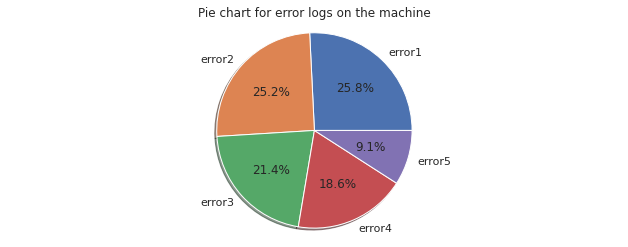

In [31]:
labels = ['error1', 'error2', 'error3', 'error4', 'error5']
sizes = [errors['errorID'].value_counts()]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.title('Pie chart for error logs on the machine')
plt.show()

## **2.3) Maintenance:**

These are scheduled and unscheduled maintenance records that correspond to both regular component inspections and errors. A log is generated if a component is replaced during the scheduled inspection or is replaced due to an error. Records created due to errors are referred to as errors, which are explained in the following sections. The maintenance data contain records from 2014 and 2015.

In [32]:
maint = pd.read_csv("/content/drive/My Drive/PdM data/PdM_maint.csv", error_bad_lines=False)

In [33]:
print('Number of data points in the maintenance data', maint.shape)
print('-'*127)
print('The attributes of the data points in the maintenance data :', maint.columns.values)
maint.head(5)

Number of data points in the maintenance data (3286, 3)
-------------------------------------------------------------------------------------------------------------------------------
The attributes of the data points in the maintenance data : ['datetime' 'machineID' 'comp']


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [34]:
maint['datetime'] = pd.to_datetime(maint['datetime'], format='%Y-%m-%d %H:%M:%S')
maint['comp'] = maint['comp'].astype('category')
print("Total Number of maintenance Records: %d" %len(maint.index))
maint.head()

Total Number of maintenance Records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [35]:
errors.describe()

,machineID
count,3919.000000
mean,51.044654
std,28.954988
min,1.000000
25%,25.000000
50%,51.000000
75%,77.000000
max,100.000000



Graphical representation of null values for errors data



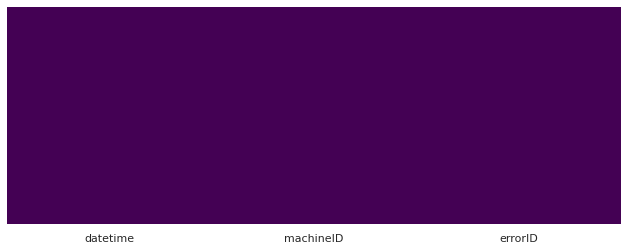

In [36]:
# Missing values in the errors
print("\nGraphical representation of null values for errors data\n")
sns.heatmap(errors.isnull(),yticklabels=False,cbar=False,cmap='viridis')

There are no missing values in the maintenance dataset.

In [37]:
print("Number of duplicate values in errors data is "+str(sum(errors.duplicated())))

Number of duplicate values in errors data is 0


In [38]:
maint['comp'].value_counts()

comp2    863
comp4    811
comp3    808
comp1    804
Name: comp, dtype: int64

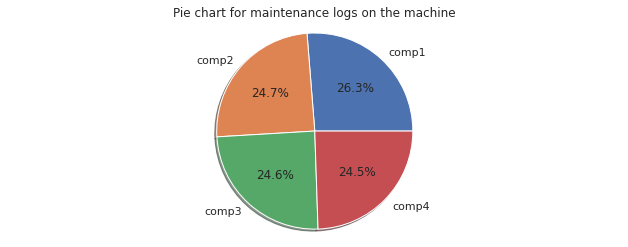

In [39]:
labels = ['comp1', 'comp2', 'comp3', 'comp4']
sizes = [maint['comp'].value_counts()]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.title('Pie chart for maintenance logs on the machine')
plt.show()

This graph depicts that component 1 is replaced maximum times during the scheduled inspection as compared to component 2,3 and 4. 

## **2.4) Machines:**

This data set includes some information about the machines: model type and age (years in service).

In [40]:
machines = pd.read_csv("/content/drive/My Drive/PdM data/PdM_machines.csv", error_bad_lines=False)

In [41]:
print('Number of data points in the machines data', machines.shape)
print('-'*127)
print('The attributes of the data points in the machines data :', machines.columns.values)
machines.head(5)

Number of data points in the machines data (100, 3)
-------------------------------------------------------------------------------------------------------------------------------
The attributes of the data points in the machines data : ['machineID' 'model' 'age']


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [42]:
machines['model'] = machines['model'].astype('category')

In [43]:
print("Total number of machines: %d" % len(machines.index))
machines.head()

Total number of machines: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [44]:
machines.describe()

,machineID,age
count,100.000000,100.000000
mean,50.500000,11.330000
std,29.011492,5.856974
min,1.000000,0.000000
25%,25.750000,6.750000
50%,50.500000,12.000000
75%,75.250000,16.000000
max,100.000000,20.000000



Graphical representation of null values for machines data



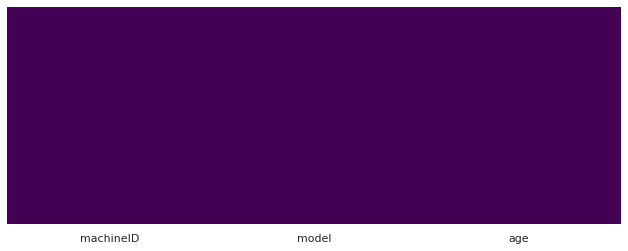

In [45]:
# Missing values in the errors
print("\nGraphical representation of null values for machines data\n")
sns.heatmap(machines.isnull(),yticklabels=False,cbar=False,cmap='viridis')

There are no missing values in the machines data.

In [46]:
print("Number of duplicate values in machines data is "+str(sum(machines.duplicated())))

Number of duplicate values in machines data is 0


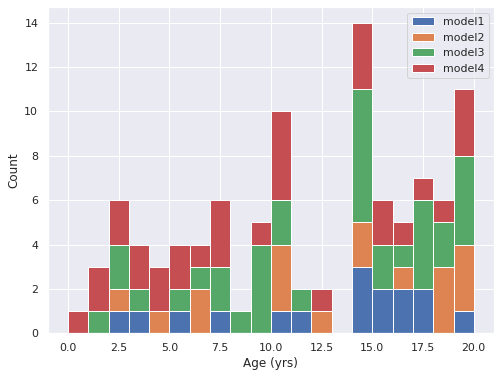

In [47]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.legend()

This graph depicts that each model of the machines has certain age means it has some years in service condition according to their count.

## **2.5) Failures:**

These are the records of component replacements due to failures. Each record has a date and time, machine ID, and failed component type.

In [48]:
failures = pd.read_csv("/content/drive/My Drive/PdM data/PdM_failures.csv", error_bad_lines=False)

In [49]:
print('Number of data points in the failures data', failures.shape)
print('-'*127)
print('The attributes of the data points in the failures data :', failures.columns.values)
failures.head(5)

Number of data points in the failures data (761, 3)
-------------------------------------------------------------------------------------------------------------------------------
The attributes of the data points in the failures data : ['datetime' 'machineID' 'failure']


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [50]:
# format datetime field which comes in as string
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

In [51]:
print("Total number of failures: %d" % len(failures.index))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [52]:
failures.describe()

,machineID
count,761.000000
mean,51.911958
std,29.515542
min,1.000000
25%,24.000000
50%,51.000000
75%,79.000000
max,100.000000



Graphical representation of null values for errors data



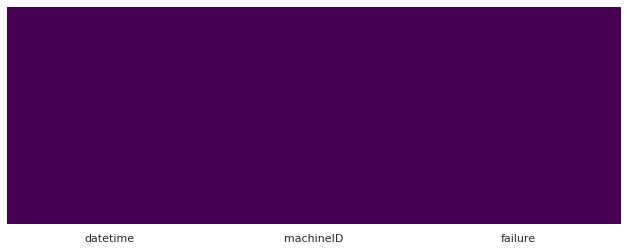

In [53]:
# Missing values in the errors
print("\nGraphical representation of null values for errors data\n")
sns.heatmap(failures.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [54]:
print("Number of duplicate values in failures data is "+str(sum(failures.duplicated())))

Number of duplicate values in failures data is 0


There are no missing and duplicate values in the failure data.

In [55]:
failures['failure'].value_counts()

comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64

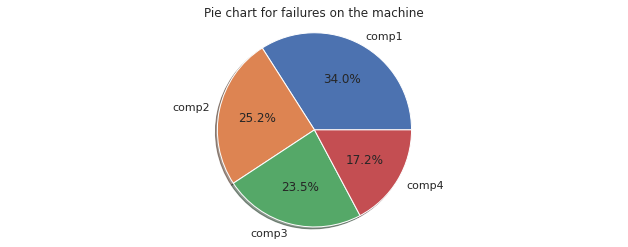

In [56]:
labels = ['comp1', 'comp2', 'comp3', 'comp4']
sizes = [failures['failure'].value_counts()]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.title('Pie chart for failures on the machine')
plt.show()

This graph depicts that component 1 is replaced maximum times due to failures as compared to component 4.

# **3) Feature Engineering**

The first step in predictive maintenance applications is feature engineering which requires bringing the different data sources together to create features that best describe a machines's health condition at a given point in time. In the next sections, several feature engineering methods are used to create features based on the properties of each data source.

### **3.1) Lag Features from Telemetry**

Telemetry data almost always comes with time stamps, making it suitable for calculating lagging features (lagging features, statistics of certain values within a time window).

We will choose the size of a window and calculate the aggregate measurements (mean, standard deviation, minimum, maximum, etc.) to represent the short-term history.

Next, we will calculate the moving average and standard deviation of the telemetry data in the last 3 hour delay window.

In [57]:
# https://stackoverflow.com/questions/54889352/how-can-i-run-a-list-of-dataframes-through-an-aggregating-loop

# create an empty list 'temp'
temp = [] 
# define the feature columns to be iterated
features = ['volt', 'rotate', 'pressure', 'vibration']
# loop
for column in features:
# append to the list 'temp' a three hour (3H) sample taking the mean for each 'column' from the 'features' list
    temp.append(pd.pivot_table(telemetry, index = 'datetime', columns = 'machineID', values = column)
    .resample('3H', closed = 'left', label = 'right').mean().unstack())
# create a dataframe to hold the information and concat the 'temp' list
telemetry3H_mean = pd.concat(temp, axis = 1)
# name the columns using the list 'features' + '1H_mean'
telemetry3H_mean.columns = [column + '_3H_mean' for column in features]
# reset the index values
telemetry3H_mean.reset_index(inplace = True)
#    return telemetry3H_mean

In [58]:
telemetry3H_mean.head()

,machineID,datetime,volt_3H_mean,rotate_3H_mean,pressure_3H_mean,vibration_3H_mean
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542


In [59]:
# https://stackoverflow.com/questions/54889352/how-can-i-run-a-list-of-dataframes-through-an-aggregating-loop

# create an empty list 'temp'
temp = [] 
# define the feature columns to be iterated
# features = ['volt', 'rotate', 'pressure', 'vibration']
# loop
for column in features:
# append to the list 'temp' a three hour (3H) sample taking the mean for each 'column' from the 'features' list
    temp.append(pd.pivot_table(telemetry, index = 'datetime', columns = 'machineID', values = column)
    .resample('3H', closed = 'left', label = 'right').std().unstack())
# create a dataframe to hold the information and concat the 'temp' list
telemetry3H_std = pd.concat(temp, axis = 1)
# name the columns using the list 'features' + '1H_mean'
telemetry3H_std.columns = [column + '_3H_std' for column in features]
# reset the index values
telemetry3H_std.reset_index(inplace = True)

In [60]:
telemetry3H_std.head()

,machineID,datetime,volt_3H_std,rotate_3H_std,pressure_3H_std,vibration_3H_std
0,1,2015-01-01 09:00:00,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,10.124584,55.084734,5.909721,5.169304
3,1,2015-01-01 18:00:00,4.673269,42.047278,4.554047,2.106108
4,1,2015-01-01 21:00:00,14.752132,47.048609,4.244158,2.207884


For capturing a longer term effect, 24 hour lag features are also calculated as below.

In [61]:
# https://stackoverflow.com/questions/54889352/how-can-i-run-a-list-of-dataframes-through-an-aggregating-loop

# create an empty list 'temp'
temp = [] 
# define the feature columns to be iterated
features = ['volt', 'rotate', 'pressure', 'vibration']
# loop
for column in features:
# append to the list 'temp' a three hour (3H) sample taking the mean for each 'column' from the 'features' list
    temp.append(pd.pivot_table(telemetry, index = 'datetime', columns = 'machineID', values = column)
    .rolling(window=24).mean().resample('3H', closed = 'left', label = 'right').first().unstack())
# create a dataframe to hold the information and concat the 'temp' list
telemetry24H_mean = pd.concat(temp, axis = 1)
# name the columns using the list 'features' + '1H_mean'
telemetry24H_mean.columns = [column + '_24H_mean' for column in features]
# reset the index values
telemetry24H_mean.reset_index(inplace = True)

In [62]:
telemetry24H_mean = telemetry24H_mean.loc[-telemetry24H_mean["volt_24H_mean"].isnull()]
telemetry24H_mean.head()

,machineID,datetime,volt_24H_mean,rotate_24H_mean,pressure_24H_mean,vibration_24H_mean
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.385160
8,1,2015-01-02 09:00:00,170.614862,446.364859,96.849785,39.736826
9,1,2015-01-02 12:00:00,169.893965,447.009407,97.715600,39.498374
10,1,2015-01-02 15:00:00,171.243444,444.233563,96.666060,40.229370
11,1,2015-01-02 18:00:00,170.792486,448.440437,95.766838,40.055214


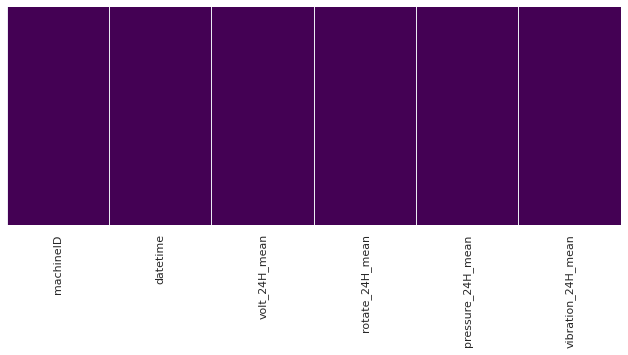

In [63]:
sns.heatmap(telemetry24H_mean.isnull(),yticklabels=False,cbar=False,cmap='viridis')

There are no missing values in the telemetry24H_mean dataframe.

In [64]:
# https://stackoverflow.com/questions/54889352/how-can-i-run-a-list-of-dataframes-through-an-aggregating-loop
# Repeat for standard deviation

# create an empty list 'temp'
temp = [] 
# define the feature columns to be iterated
features = ['volt', 'rotate', 'pressure', 'vibration']
# loop
for column in features:
# append to the list 'temp' a three hour (3H) sample taking the mean for each 'column' from the 'features' list
    temp.append(pd.pivot_table(telemetry, index = 'datetime', columns = 'machineID', values = column)
    .rolling(window=24).std().resample('3H', closed = 'left', label = 'right').first().unstack())
# create a dataframe to hold the information and concat the 'temp' list
telemetry24H_std = pd.concat(temp, axis = 1)
# name the columns using the list 'features' + '1H_mean'
telemetry24H_std.columns = [column + '_24H_std' for column in features]
# reset the index values
telemetry24H_std.reset_index(inplace = True)

In [65]:
telemetry24H_std = telemetry24H_std.loc[-telemetry24H_std["volt_24H_std"].isnull()]
telemetry24H_std.head(10)

,machineID,datetime,volt_24H_std,rotate_24H_std,pressure_24H_std,vibration_24H_std
7,1,2015-01-02 06:00:00,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,13.954518,43.490234,8.061653,5.898069
12,1,2015-01-02 21:00:00,14.402740,42.626186,10.408012,5.941890
13,1,2015-01-03 00:00:00,15.513819,40.395881,10.833294,5.737671
14,1,2015-01-03 03:00:00,15.726970,39.648116,11.904700,5.601191
15,1,2015-01-03 06:00:00,15.635083,41.828592,11.326412,5.583521
16,1,2015-01-03 09:00:00,13.995465,40.843882,11.036546,5.561553


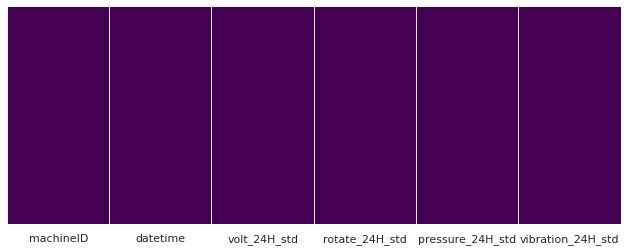

In [66]:
# Checking missing values 
sns.heatmap(telemetry24H_std.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Now there are no missing values in the telemetry_std_24h dataframe.

Next, the columns of the feature datasets created earlier are merged to create the final feature set from telemetry.

In [67]:
# merge all columns of feature sets which created earlier
telemetry_feat = pd.concat([telemetry3H_mean,   # # We combine the features created so far.
                            telemetry3H_std.iloc[:, 2:6],  # We take the values 2: 6 to avoid duplicate IDs and dates.
                            telemetry24H_mean.iloc[:, 2:6],
                            telemetry24H_std.iloc[:, 2:6]], axis=1).dropna() 

In [68]:
telemetry_feat.head()

,machineID,datetime,volt_3H_mean,rotate_3H_mean,pressure_3H_mean,vibration_3H_mean,volt_3H_std,rotate_3H_std,pressure_3H_std,vibration_3H_std,volt_24H_mean,rotate_24H_mean,pressure_24H_mean,vibration_24H_mean,volt_24H_std,rotate_24H_std,pressure_24H_std,vibration_24H_std
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069


In [69]:
telemetry_feat.shape

(291300, 18)

In [70]:
telemetry_feat.describe()

,machineID,volt_3H_mean,rotate_3H_mean,pressure_3H_mean,vibration_3H_mean,volt_3H_std,rotate_3H_std,pressure_3H_std,vibration_3H_std,volt_24H_mean,rotate_24H_mean,pressure_24H_mean,vibration_24H_mean,volt_24H_std,rotate_24H_std,pressure_24H_std,vibration_24H_std
count,291300.00000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,170.771416,446.612973,100.855301,40.384328,13.299858,44.456335,8.885822,4.440660,170.772579,446.613440,100.854547,40.384564,14.918849,49.947916,10.046687,5.002065
std,28.86612,9.497201,33.122865,7.408854,3.476641,6.966647,23.216421,4.656341,2.320066,4.716970,18.074248,4.733098,2.059861,2.260726,7.682126,1.713726,0.799820
min,1.00000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,266.010419,91.057429,35.060087,6.380619,18.385248,4.145308,2.144863
25%,25.75000,164.445576,427.568132,96.238173,38.147839,8.027455,26.903567,5.370647,2.684308,168.070890,441.549802,98.668589,39.354062,13.358663,44.668824,8.924317,4.460347
50%,50.50000,170.430790,448.385564,100.233139,40.146085,12.495595,41.795700,8.345785,4.173854,170.210913,449.212554,100.097694,40.072752,14.853948,49.613807,9.921407,4.958594
75%,75.25000,176.607051,468.447680,104.404520,42.227392,17.689118,59.103715,11.789645,5.898997,172.459612,456.368008,101.611121,40.833364,16.394764,54.821318,10.980498,5.484480
max,100.00000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,499.096975,152.310351,61.932124,27.664538,103.819404,28.654103,12.325783


### **3.2) Lag Features on Errors**

Like telemetry data, errors come with timestamps. An important difference is that the error IDs are categorical values and should not be averaged over time intervals like the telemetry measurements. Instead, we count the number of errors of each type in a lagging window. We begin by reformatting the error data to have one entry per machine per time at which at least one error occurred:

In [71]:
# We start by reformatting the error data to have one input per machine per time when at least one error occurred.
# Create a column for each type of error.
errorcount = pd.get_dummies(errors.set_index('datetime')).reset_index()
errorcount
errorcount.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
errorcount.head(15)

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-03 07:00:00,1,1,0,0,0,0
1,2015-01-03 20:00:00,1,0,0,1,0,0
2,2015-01-04 06:00:00,1,0,0,0,0,1
3,2015-01-10 15:00:00,1,0,0,0,1,0
4,2015-01-22 10:00:00,1,0,0,0,1,0
5,2015-01-25 15:00:00,1,0,0,0,1,0
6,2015-01-27 04:00:00,1,1,0,0,0,0
7,2015-03-03 22:00:00,1,0,1,0,0,0
8,2015-03-05 06:00:00,1,1,0,0,0,0
9,2015-03-20 18:00:00,1,1,0,0,0,0


In [72]:
# We combine errors for a given machine at a specific time.
errorcount = errorcount.groupby(['machineID','datetime']).sum().reset_index()
errorcount.head(15)

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0
5,1,2015-01-25 15:00:00,0,0,0,1,0
6,1,2015-01-27 04:00:00,1,0,0,0,0
7,1,2015-03-03 22:00:00,0,1,0,0,0
8,1,2015-03-05 06:00:00,1,0,0,0,0
9,1,2015-03-20 18:00:00,1,0,0,0,0


In [73]:
# We check that the registered errors exist in the available machines filling us with 0 , 
# non-matches so we only search for a match with datetime and machineID.
errorcount_filtered = telemetry[["datetime", "machineID"]].merge(errorcount, on=["machineID", "datetime"],
    how="left").fillna(0.0)

In [74]:
errorcount_filtered.head()

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,0.0,0.0,0.0,0.0,0.0


In [75]:
errorcount_filtered.describe()

,machineID,error1,error2,error3,error4,error5
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,0.001153,0.001128,0.000957,0.000830,0.000406
std,28.866087,0.033934,0.033563,0.030913,0.028795,0.020154
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From the above table, we found that there is no deviation in the errors.

In [76]:
# We calculate the total number of errors for each type of error during 24-hour periods.
# We will take points every 3 hours.

temp = []
features = ['error%d' % i for i in range(1,6)]
for column in features:
    temp.append(pd.pivot_table(errorcount_filtered, index='datetime', columns='machineID', values=column).rolling(window=24).sum().resample('3H',
                closed='left', label='right').first().unstack())
error_count_total = pd.concat(temp, axis=1)
error_count_total.columns = [i + 'count' for i in features]
error_count_total.reset_index(inplace=True)
error_count_total = error_count_total.dropna()
error_count_total.describe()

,machineID,error1count,error2count,error3count,error4count,error5count
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,0.027649,0.027069,0.022907,0.019904,0.009753
std,28.86612,0.166273,0.164429,0.151453,0.140820,0.098797
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2.000000,2.000000,2.000000,2.000000,2.000000


In [77]:
error_count_total.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


In [78]:
error_count_total["error5count"].unique()

array([0., 1., 2.])

In [79]:
error_count_total.describe()

,machineID,error1count,error2count,error3count,error4count,error5count
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,0.027649,0.027069,0.022907,0.019904,0.009753
std,28.86612,0.166273,0.164429,0.151453,0.140820,0.098797
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2.000000,2.000000,2.000000,2.000000,2.000000


### **3.3) Replacement records of component:**

A crucial data set in this example is the maintenance records which contain the information of component replacement records. Possible features from this data set can be, for example, the number of replacements of each component in the last 3 months to incorporate the frequency of replacements. However, more relevent information would be to calculate how long it has been since a component is last replaced as that would be expected to correlate better with component failures since the longer a component is used, the more degradation should be expected.

As a side note, creating lagging features from maintenance data is not as straightforward as for telemetry and errors, so the features from this data are generated in a more custom way. This type of ad-hoc feature engineering is very common in predictive maintenance since domain knowledge plays a big role in understanding the predictors of a problem. In the following, the days since last component replacement are calculated for each component type as features from the maintenance data.


In [80]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [81]:
# create a column for each error type
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

In [82]:
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2014-06-01 06:00:00,1,0,1,0,0
1,2014-07-16 06:00:00,1,0,0,0,1
2,2014-07-31 06:00:00,1,0,0,1,0
3,2014-12-13 06:00:00,1,1,0,0,0
4,2015-01-05 06:00:00,1,0,0,0,1


In [83]:
# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

In [84]:
comp_rep.head()

,machineID,datetime,comp1,comp2,comp3,comp4
0,1,2014-06-01 06:00:00,0,1,0,0
1,1,2014-07-16 06:00:00,0,0,0,1
2,1,2014-07-31 06:00:00,0,0,1,0
3,1,2014-12-13 06:00:00,1,0,0,0
4,1,2015-01-05 06:00:00,1,0,0,1


In [85]:
# add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep, on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])
comp_rep.head()                                                   

,datetime,machineID,comp1,comp2,comp3,comp4
876100,2014-06-01 06:00:00,1,0.0,1.0,0.0,0.0
876101,2014-07-16 06:00:00,1,0.0,0.0,0.0,1.0
876102,2014-07-31 06:00:00,1,0.0,0.0,1.0,0.0
876103,2014-12-13 06:00:00,1,1.0,0.0,0.0,0.0
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0


In [86]:
components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

In [87]:
# remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

In [88]:
# replace dates of most recent component change with days since most recent component change
for comp in components: 
  comp_rep[comp] = (comp_rep["datetime"] - pd.to_datetime(comp_rep[comp])) / np.timedelta64(1, "D")
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


In [89]:
comp_rep.describe()

,machineID,comp1,comp2,comp3,comp4
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,53.525185,51.540806,52.725962,53.834191
std,28.866087,62.491679,59.269254,58.873114,59.707978
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,13.291667,12.125000,13.125000,13.000000
50%,50.500000,32.791667,29.666667,32.291667,32.500000
75%,75.250000,68.708333,66.541667,67.333333,70.458333
max,100.000000,491.958333,348.958333,370.958333,394.958333


## **3.4) Machine features**

The machine features can be used without further modification. These include descriptive information about the type of each machine and its age (number of years in service). If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

Lastly, we merge all the feature data sets we created earlier to get the final feature matrix.

In [90]:
telemetry_feat

,machineID,datetime,volt_3H_mean,rotate_3H_mean,pressure_3H_mean,vibration_3H_mean,volt_3H_std,rotate_3H_std,pressure_3H_std,vibration_3H_std,volt_24H_mean,rotate_24H_mean,pressure_24H_mean,vibration_24H_mean,volt_24H_std,rotate_24H_std,pressure_24H_std,vibration_24H_std
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292094,100,2015-12-31 18:00:00,177.758754,458.391629,103.183160,46.846592,13.147011,75.100940,3.111700,3.576693,169.764418,454.478787,100.873360,39.094339,15.331755,60.839923,7.891711,5.269038
292095,100,2015-12-31 21:00:00,166.078945,424.431184,98.344409,30.907459,29.351231,69.348245,16.940674,3.731256,171.547643,452.351565,101.789714,39.184285,16.429023,62.147934,7.475540,5.448962
292096,100,2016-01-01 00:00:00,158.327984,504.056262,108.055441,40.109705,9.605817,78.036116,9.154932,3.379639,168.806645,459.502212,100.919285,38.150193,17.019808,64.730136,8.961444,5.833191
292097,100,2016-01-01 03:00:00,170.306956,438.653616,102.346227,47.481232,8.457322,43.021553,0.785721,3.198928,169.011763,465.923073,101.568092,39.456302,17.096392,64.718132,9.420879,5.738756


In [91]:
final_features = telemetry_feat.merge(error_count_total, on=['datetime', 'machineID'], how='left')
final_features = final_features.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_features = final_features.merge(machines, on=['machineID'], how='left')
final_features.head()

,machineID,datetime,volt_3H_mean,rotate_3H_mean,pressure_3H_mean,vibration_3H_mean,volt_3H_std,rotate_3H_std,pressure_3H_std,vibration_3H_std,volt_24H_mean,rotate_24H_mean,pressure_24H_mean,vibration_24H_mean,volt_24H_std,rotate_24H_std,pressure_24H_std,vibration_24H_std,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209,0.0,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231,0.0,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076,0.0,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944,0.0,0.0,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069,0.0,0.0,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18


In [92]:
final_features.describe()

,machineID,volt_3H_mean,rotate_3H_mean,pressure_3H_mean,vibration_3H_mean,volt_3H_std,rotate_3H_std,pressure_3H_std,vibration_3H_std,volt_24H_mean,rotate_24H_mean,pressure_24H_mean,vibration_24H_mean,volt_24H_std,rotate_24H_std,pressure_24H_std,vibration_24H_std,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,291300.00000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,170.771416,446.612973,100.855301,40.384328,13.299858,44.456335,8.885822,4.440660,170.772579,446.613440,100.854547,40.384564,14.918849,49.947916,10.046687,5.002065,0.027659,0.027075,0.022901,0.019907,0.009756,53.350748,51.318963,52.512108,53.619118,11.330000
std,28.86612,9.497201,33.122865,7.408854,3.476641,6.966647,23.216421,4.656341,2.320066,4.716970,18.074248,4.733098,2.059861,2.260726,7.682126,1.713726,0.799820,0.166301,0.164446,0.151435,0.140832,0.098813,62.418063,59.140743,58.765904,59.606886,5.827625
min,1.00000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,266.010419,91.057429,35.060087,6.380619,18.385248,4.145308,2.144863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,164.445576,427.568132,96.238173,38.147839,8.027455,26.903567,5.370647,2.684308,168.070890,441.549802,98.668589,39.354062,13.358663,44.668824,8.924317,4.460347,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.000000,13.000000,12.875000,6.750000
50%,50.50000,170.430790,448.385564,100.233139,40.146085,12.495595,41.795700,8.345785,4.173854,170.210913,449.212554,100.097694,40.072752,14.853948,49.613807,9.921407,4.958594,0.000000,0.000000,0.000000,0.000000,0.000000,32.625000,29.500000,32.125000,32.375000,12.000000
75%,75.25000,176.607051,468.447680,104.404520,42.227392,17.689118,59.103715,11.789645,5.898997,172.459612,456.368008,101.611121,40.833364,16.394764,54.821318,10.980498,5.484480,0.000000,0.000000,0.000000,0.000000,0.000000,68.500000,66.250000,67.000000,70.125000,16.000000
max,100.00000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,499.096975,152.310351,61.932124,27.664538,103.819404,28.654103,12.325783,2.000000,2.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000


In [93]:
final_features.shape

(291300, 29)

In [94]:
print("Number of duplicate values in final features are "+str(sum(final_features.duplicated())))

Number of duplicate values in final features are 0


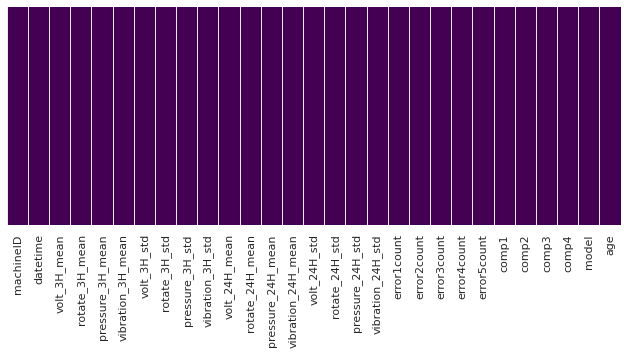

In [95]:
# Checking missing values 
sns.heatmap(final_features.isnull(),yticklabels=False,cbar=False,cmap='viridis')

After merging all the features with telemetry data, we found that there are no missing and duplicate values in the figure.

## **3.5) Label Construction**

When we are using multi-class classification for predicting failure due to a problem, labelling is done by taking a time window prior to the failure of an asset and labelling the feature records that fall into that window as "about to fail due to a problem"

This time window should be picked according to the business case: in some situations it may be enough to predict failures hours in advance, while in others days or weeks may be needed to allow e.g. for arrival of replacement parts.

The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. **More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4).** Below, a categorical failure feature is created to serve as the label. All records within a 24 hour window before a failure of component 1 have failure=comp1, and so on for components 2, 3, and 4; all records not within 24 hours of a component failure have failure=none.

In [96]:
final_dataset = final_features.merge(failures, on=["datetime", "machineID"], how="left")
final_dataset["failure"] = final_dataset["failure"].astype(object).fillna(method="bfill", limit=7)
final_dataset["failure"] = final_dataset["failure"].fillna("none")
final_dataset["failure"] = final_dataset["failure"].astype("category")
final_dataset.head()

,machineID,datetime,volt_3H_mean,rotate_3H_mean,pressure_3H_mean,vibration_3H_mean,volt_3H_std,rotate_3H_std,pressure_3H_std,vibration_3H_std,volt_24H_mean,rotate_24H_mean,pressure_24H_mean,vibration_24H_mean,volt_24H_std,rotate_24H_std,pressure_24H_std,vibration_24H_std,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209,0.0,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231,0.0,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076,0.0,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944,0.0,0.0,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,none
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069,0.0,0.0,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18,none


Below is an example of records that are labeled as `failure=comp2` in the failure column. Notice that the first 8 records all occur in the 24-hour window before the first recorded failure of component 2. The next 8 records are within the 24 hour window before another failure of component 2.

In [97]:
final_dataset['failure'].unique() 

[none, comp4, comp1, comp2, comp3]
Categories (5, object): [none, comp4, comp1, comp2, comp3]

In [98]:
len(final_dataset['failure'].unique())

5

In [99]:
pd.value_counts(final_dataset.failure)

none     285684
comp2      1985
comp1      1464
comp4      1240
comp3       968
Name: failure, dtype: int64

After the value counts of target varibale, here we see 'none' label has maximum value count after merging all csv files into final dataframe. Also we are selecting the first 16 records of 'none' by using .loc

In [100]:
final_dataset.loc[final_dataset['failure'] == 'none'][:16]

,machineID,datetime,volt_3H_mean,rotate_3H_mean,pressure_3H_mean,vibration_3H_mean,volt_3H_std,rotate_3H_std,pressure_3H_std,vibration_3H_std,volt_24H_mean,rotate_24H_mean,pressure_24H_mean,vibration_24H_mean,volt_24H_std,rotate_24H_std,pressure_24H_std,vibration_24H_std,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209,0.0,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231,0.0,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076,0.0,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944,0.0,0.0,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,none
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069,0.0,0.0,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18,none
5,1,2015-01-02 21:00:00,163.278466,446.493166,104.387585,38.068116,21.580492,41.380958,20.725597,6.932127,170.556674,452.267095,98.065860,40.033247,14.402740,42.626186,10.408012,5.941890,0.0,0.0,0.0,0.0,0.0,20.625,215.625,155.625,170.625,model3,18,none
6,1,2015-01-03 00:00:00,172.191198,434.214692,93.747282,39.716482,16.369836,14.636041,18.817326,3.426997,168.460525,451.031783,99.273286,38.903462,15.513819,40.395881,10.833294,5.737671,0.0,0.0,0.0,0.0,0.0,20.750,215.750,155.750,170.750,model3,18,none
7,1,2015-01-03 03:00:00,175.210027,504.845430,108.512153,37.763933,5.991921,16.062702,6.382608,3.449468,169.772951,447.502464,99.005946,39.389725,15.726970,39.648116,11.904700,5.601191,0.0,0.0,0.0,0.0,0.0,20.875,215.875,155.875,170.875,model3,18,none
8,1,2015-01-03 06:00:00,181.690108,472.783187,93.395164,38.621099,11.514450,47.880443,2.177029,7.670520,170.900562,453.864597,100.877342,38.696225,15.635083,41.828592,11.326412,5.583521,0.0,0.0,0.0,0.0,0.0,21.000,216.000,156.000,171.000,model3,18,none
9,1,2015-01-03 09:00:00,172.382935,505.141261,98.524373,49.965572,7.065150,56.849540,5.230039,2.687565,169.533156,454.785072,100.050567,39.449734,13.995465,40.843882,11.036546,5.561553,0.0,0.0,0.0,0.0,0.0,21.125,216.125,156.125,171.125,model3,18,none


In [101]:
final_dataset.shape

(291341, 30)

In [102]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
# Convert categorical variable into dummy/indicator variables.

dummy_model = pd.get_dummies(final_dataset["model"])
final_dataset = pd.concat([final_dataset, dummy_model], axis=1)
final_dataset.drop("model", axis=1, inplace=True)

In [103]:
final_dataset.head()

,machineID,datetime,volt_3H_mean,rotate_3H_mean,pressure_3H_mean,vibration_3H_mean,volt_3H_std,rotate_3H_std,pressure_3H_std,vibration_3H_std,volt_24H_mean,rotate_24H_mean,pressure_24H_mean,vibration_24H_mean,volt_24H_std,rotate_24H_std,pressure_24H_std,vibration_24H_std,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age,failure,model1,model2,model3,model4
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209,0.0,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,18,none,0,0,1,0
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231,0.0,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,18,none,0,0,1,0
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076,0.0,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,18,none,0,0,1,0
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944,0.0,0.0,0.0,0.0,0.0,20.375,215.375,155.375,170.375,18,none,0,0,1,0
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069,0.0,0.0,0.0,0.0,0.0,20.500,215.500,155.500,170.500,18,none,0,0,1,0


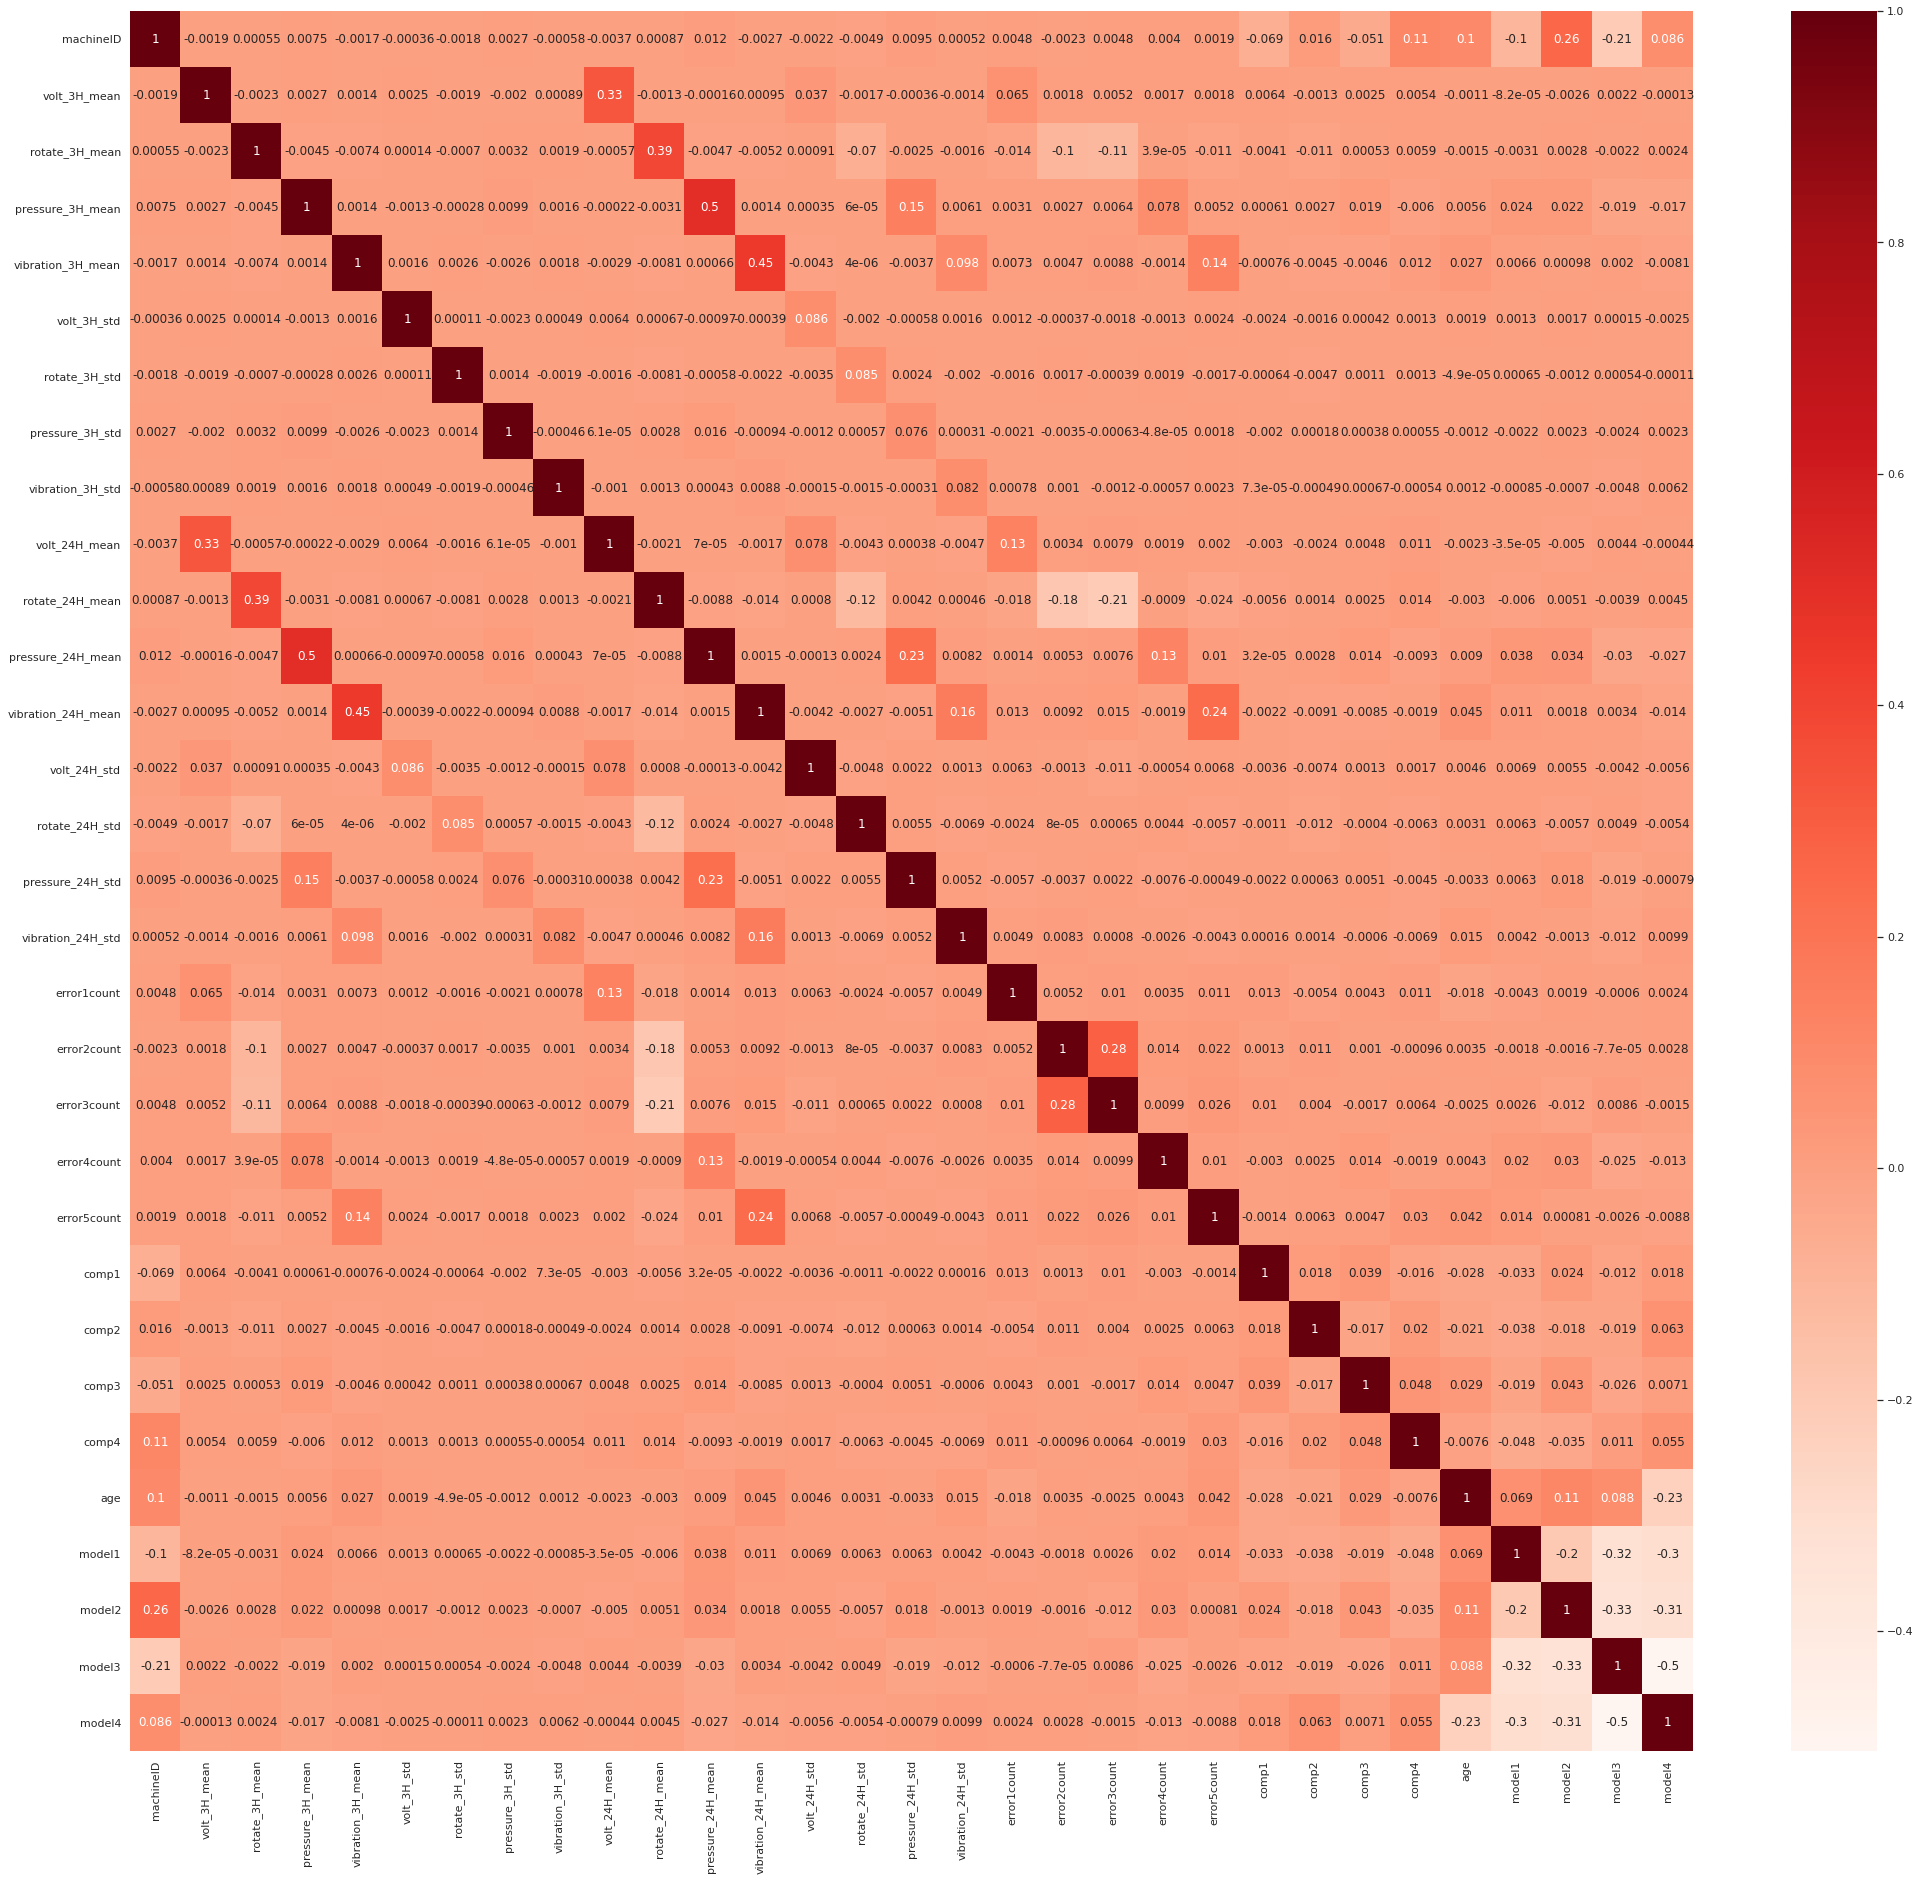

In [104]:
# Analysis of correlation By Using Pearson 
plt.figure(figsize=(35,32))
cor = final_dataset.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [105]:
# Saving the final dataset 
final_dataset.to_csv('final_dataset.csv')

Here we saved the final dataset which is created after combining all like telemerty, error, etc. in one csv file. On the basis of this file, we proceed for model evaluation.

In [106]:
print('There are number of data points in final_dataset : ', final_dataset.shape[0])
print('There are number of features in final_dataset: ', final_dataset.shape[1])
print()
print('The features in the final_dataset : ', final_dataset.columns.values)
final_dataset.head()

There are number of data points in final_dataset :  291341
There are number of features in final_dataset:  33

The features in the final_dataset :  ['machineID' 'datetime' 'volt_3H_mean' 'rotate_3H_mean' 'pressure_3H_mean'
 'vibration_3H_mean' 'volt_3H_std' 'rotate_3H_std' 'pressure_3H_std'
 'vibration_3H_std' 'volt_24H_mean' 'rotate_24H_mean' 'pressure_24H_mean'
 'vibration_24H_mean' 'volt_24H_std' 'rotate_24H_std' 'pressure_24H_std'
 'vibration_24H_std' 'error1count' 'error2count' 'error3count'
 'error4count' 'error5count' 'comp1' 'comp2' 'comp3' 'comp4' 'age'
 'failure' 'model1' 'model2' 'model3' 'model4']


,machineID,datetime,volt_3H_mean,rotate_3H_mean,pressure_3H_mean,vibration_3H_mean,volt_3H_std,rotate_3H_std,pressure_3H_std,vibration_3H_std,volt_24H_mean,rotate_24H_mean,pressure_24H_mean,vibration_24H_mean,volt_24H_std,rotate_24H_std,pressure_24H_std,vibration_24H_std,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age,failure,model1,model2,model3,model4
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209,0.0,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,18,none,0,0,1,0
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231,0.0,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,18,none,0,0,1,0
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076,0.0,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,18,none,0,0,1,0
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944,0.0,0.0,0.0,0.0,0.0,20.375,215.375,155.375,170.375,18,none,0,0,1,0
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069,0.0,0.0,0.0,0.0,0.0,20.500,215.500,155.500,170.500,18,none,0,0,1,0


In [107]:
overview = final_dataset.describe()
overview

,machineID,volt_3H_mean,rotate_3H_mean,pressure_3H_mean,vibration_3H_mean,volt_3H_std,rotate_3H_std,pressure_3H_std,vibration_3H_std,volt_24H_mean,rotate_24H_mean,pressure_24H_mean,vibration_24H_mean,volt_24H_std,rotate_24H_std,pressure_24H_std,vibration_24H_std,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
count,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000,291341.000000
mean,50.499243,170.772904,446.605411,100.856760,40.385035,13.300147,44.456192,8.885581,4.440731,170.773862,446.606055,100.855709,40.385353,14.918834,49.948072,10.046652,5.002088,0.027724,0.027164,0.022990,0.019949,0.009837,53.350081,51.314525,52.510320,53.614339,11.330321,0.160022,0.170004,0.349982,0.319993
std,28.866522,9.498823,33.131243,7.411867,3.477584,6.967092,23.216200,4.656316,2.320161,4.720059,18.090768,4.737010,2.061740,2.260679,7.682153,1.713672,0.799818,0.166505,0.164701,0.151716,0.140975,0.099214,62.422314,59.140184,58.764991,59.605785,5.827532,0.366627,0.375637,0.476965,0.466474
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,266.010419,91.057429,35.060087,6.380619,18.385248,4.145308,2.144863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,164.446156,427.562122,96.238559,38.147924,8.027156,26.904066,5.370336,2.684279,168.070941,441.546596,98.668585,39.354134,13.358638,44.669022,8.924317,4.460362,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.000000,13.000000,12.875000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,170.431738,448.381061,100.233703,40.146346,12.495726,41.795503,8.345753,4.173891,170.211090,449.211343,100.097802,40.072824,14.853989,49.614016,9.921373,4.958602,0.000000,0.000000,0.000000,0.000000,0.000000,32.625000,29.500000,32.125000,32.375000,12.000000,0.000000,0.000000,0.000000,0.000000
75%,75.000000,176.608355,468.444174,104.404725,42.228008,17.689865,59.102266,11.789276,5.899338,172.460120,456.367622,101.611396,40.833579,16.394758,54.821369,10.980490,5.484486,0.000000,0.000000,0.000000,0.000000,0.000000,68.500000,66.250000,67.000000,70.125000,16.000000,0.000000,0.000000,1.000000,1.000000
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,499.096975,152.310351,61.932124,27.664538,103.819404,28.654103,12.325783,2.000000,2.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000,1.000000,1.000000,1.000000,1.000000


**Convert Strings to Datetime in Pandas DataFrame**

In [108]:
final_dataset['datetime'] = pd.to_datetime(final_dataset['datetime'], format='%Y-%m-%dT%H:%M:%S')
print (final_dataset)

        machineID            datetime  volt_3H_mean  ...  model2  model3  model4
0               1 2015-01-02 06:00:00    180.133784  ...       0       1       0
1               1 2015-01-02 09:00:00    176.364293  ...       0       1       0
2               1 2015-01-02 12:00:00    160.384568  ...       0       1       0
3               1 2015-01-02 15:00:00    170.472461  ...       0       1       0
4               1 2015-01-02 18:00:00    163.263806  ...       0       1       0
...           ...                 ...           ...  ...     ...     ...     ...
291336        100 2015-12-31 18:00:00    177.758754  ...       0       0       1
291337        100 2015-12-31 21:00:00    166.078945  ...       0       0       1
291338        100 2016-01-01 00:00:00    158.327984  ...       0       0       1
291339        100 2016-01-01 03:00:00    170.306956  ...       0       0       1
291340        100 2016-01-01 06:00:00    182.525427  ...       0       0       1

[291341 rows x 33 columns]


In [109]:
# https://stackoverflow.com/questions/54312802/pandas-convert-from-datetime-to-integer-timestamp
final_dataset.datetime = final_dataset.datetime.astype(int) / 10 ** 9 # convert from datetime to integer timestamp

When working with time series like this example, the Training, Validation, and Testing department must be done carefully to avoid overestimating the performance of the models. In predictive maintenance, functionality is typically generated using offset aggregates: records in the same time window are likely to have identical labels and similar function values. These correlations can give an "undue advantage" to a model in predicting a test set data set that shares its time window with a learning set data set. Therefore, we divide the records into large parts into training, validation and test sets to minimize the number of time intervals shared between them.

In [110]:
# Establish the datetime corresponding to the records that will be used for training and testing.
datetime = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')],
                   [pd.to_datetime('2015-10-30 01:00:00'), pd.to_datetime('2015-11-01 01:00:00')]]

In [111]:
X = final_dataset.drop(['datetime', 'machineID', 'failure'], axis=1)
y = final_dataset.failure

# **4) Splitting the train and test data**

In [112]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, stratify =final_dataset['failure'])
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [113]:
#finding out the results
print("The shape of train data:", X_train.shape)
print("The shape of train data:",y_train.shape)
print("The shape of test data:",X_test.shape)
print("The shape of test data:",y_test.shape)
print("The shape of cv data:", X_cv.shape)
print("The shape of cv data:", y_cv.shape)

The shape of train data: (186457, 30)
The shape of train data: (186457,)
The shape of test data: (58269, 30)
The shape of test data: (58269,)
The shape of cv data: (46615, 30)
The shape of cv data: (46615,)


## **4.1) Feature Improtance**

In [114]:
print(format('How to visualise XGBoost feature importance','*^82'))
# load libraries
from sklearn import datasets
from sklearn import metrics
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

model = XGBClassifier(n_jobs = -1)
model.fit(X_train, y_train)
# make predictions
y_pred = model.predict(X_test)

*******************How to visualise XGBoost feature importance********************


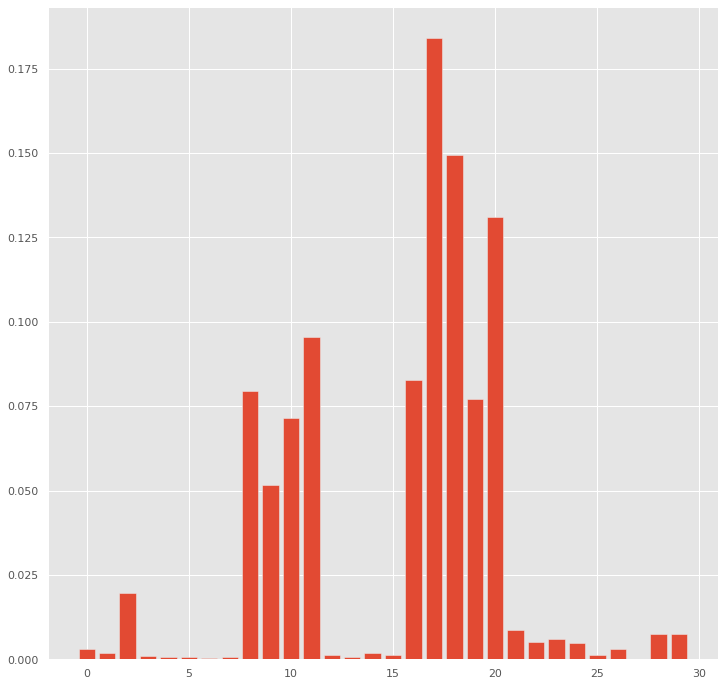

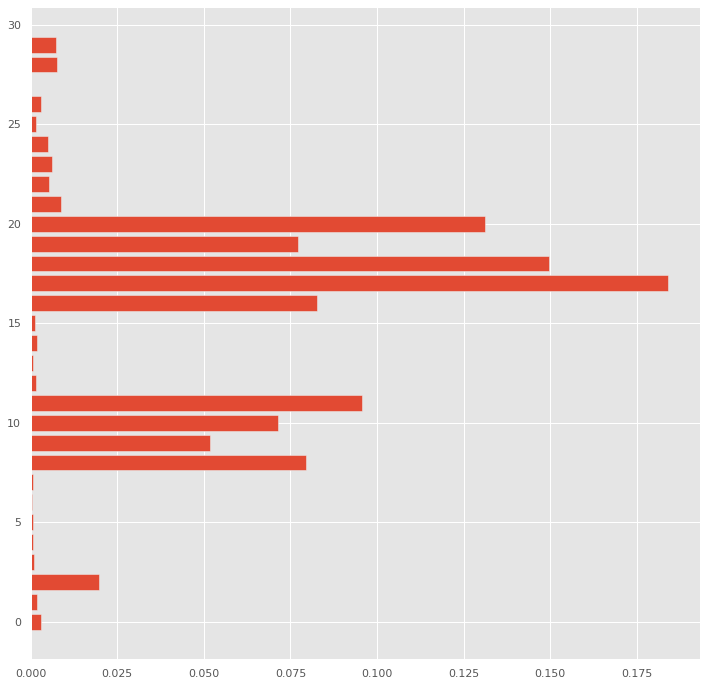

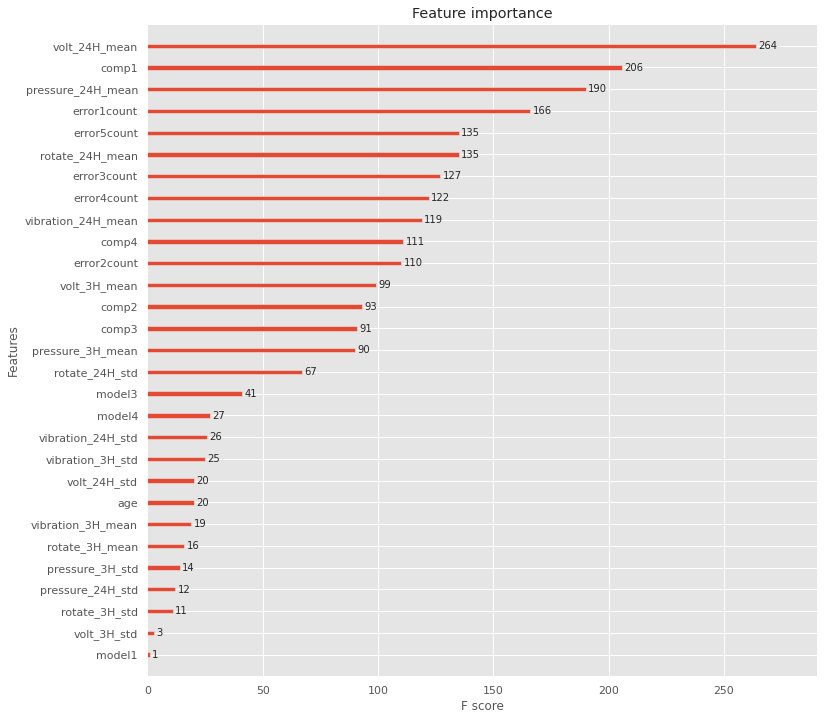

In [115]:
plt.figure(figsize=(12,12))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

plt.figure(figsize=(12,12))
plt.barh(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()    

fig, ax = plt.subplots(figsize=(12,12))
plot_importance(model, ax = ax)
plt.show()

As we see in this above plotting, there are most important features like volt 24H mean, comp1,error2count, error3count, error5count, etc.

In [ ]:
pip install shap

     |████████████████████████████████| 276kB 2.9MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394134 sha256=17e9d40f2edab9750dcc9fde7c0ca90af6a5bd59fd40c34826ab2d9f95523500
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


## **4.2) Interpreting our model with Confidence**

SHAP is a powerful tool for interpreting our model with more confidence,It makes the process simple and understandable.We will try SHAP in this section for interpret our model.



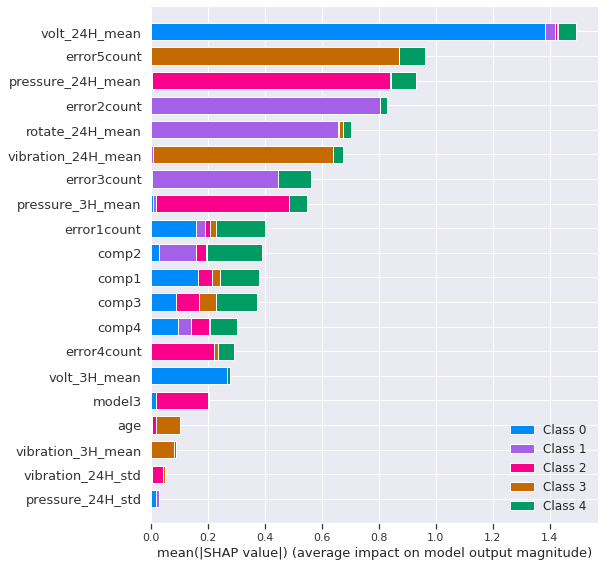

In [ ]:
import shap

shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

This figure explains the feature importance and it's influence on different class. For feature error1count and volt_24H_mean, its SHAP value is high for class 0 means it influences predicting class 0 is more than any other class.

Summary plot for class 0

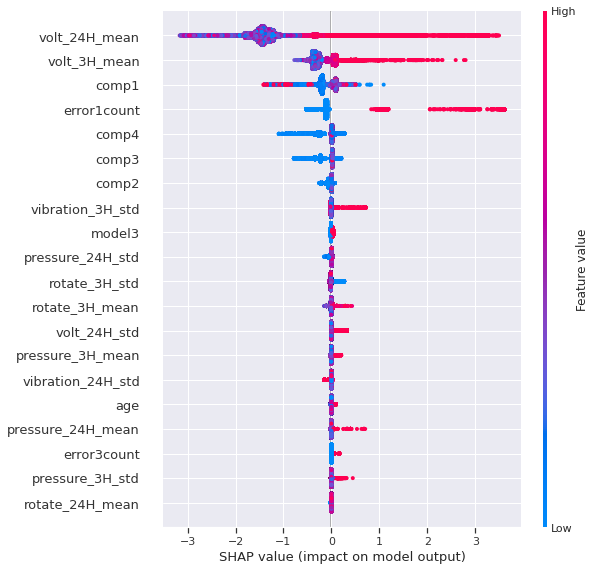

In [ ]:
shap.summary_plot(shap_values[0], X_train)

Here we can see that the variables are ranked in the descending order.

The most important variable error1count.
Lower value of error1count has a high and positive impact on the model predicting class 0 .
Lower value of error1count the model tends to classify it to class 0.


Summary plot for class 1

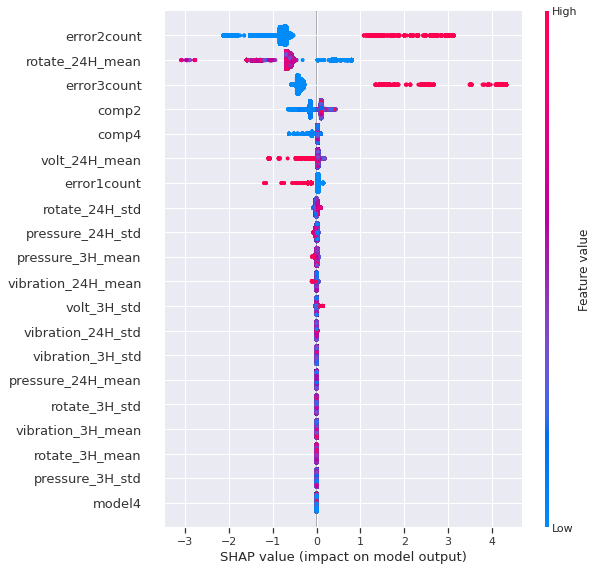

In [ ]:
shap.summary_plot(shap_values[1], X_train)

After doing feature importance, we are going to see extraction of features. After extraction of features, what will be the impact on the model evaluation by selecting most important features? Here we are using selectKbest for the feature extraction.

In [ ]:
from sklearn.feature_selection import SelectKBest # Univariate Feature Selection
from sklearn.feature_selection import chi2 # To apply Univariate Feature Selection
from sklearn.feature_selection import RFE # Recursive Feature Selection
from sklearn.feature_selection import RFECV # Recursive Feature Selection with Cross Validation
from sklearn.decomposition import PCA # To apply PCA
from sklearn import preprocessing # To get MinMax Scaler function


In [116]:
from sklearn.feature_selection import SelectKBest # Univariate Feature Selection
from sklearn.feature_selection import chi2 # To apply Univariate Feature Selection

# Initialize SelectKBest function
UnivariateFeatureSelection = SelectKBest(chi2, k=5).fit(X_train, y_train)

In [117]:
# Creating a dict to visualize which features were selected with the highest score
diccionario = {key:value for (key, value) in zip(UnivariateFeatureSelection.scores_, X_train.columns)}
sorted(diccionario.items())

[(1.362229008792526, 'pressure_24H_std'),
 (2.349315663042188, 'vibration_24H_std'),
 (4.773676544262896, 'vibration_3H_std'),
 (5.337513427142386, 'pressure_3H_std'),
 (5.8137463060868235, 'volt_24H_std'),
 (19.630904697879714, 'volt_3H_std'),
 (19.653775738345068, 'rotate_3H_std'),
 (23.157608984614555, 'rotate_24H_std'),
 (217.56982972392132, 'model3'),
 (221.4205869636984, 'model4'),
 (387.3267008731961, 'model2'),
 (484.29939515468044, 'model1'),
 (1963.1112498502616, 'vibration_3H_mean'),
 (1981.8350658469365, 'vibration_24H_mean'),
 (1992.4763814201913, 'age'),
 (2266.7158117484973, 'volt_24H_mean'),
 (2304.964155897308, 'volt_3H_mean'),
 (3720.7055917850503, 'pressure_3H_mean'),
 (3787.7678858251957, 'pressure_24H_mean'),
 (6090.552790774853, 'comp2'),
 (11871.367609914689, 'comp1'),
 (14873.444194814014, 'comp3'),
 (17420.169459562116, 'rotate_24H_mean'),
 (17539.85097985791, 'rotate_3H_mean'),
 (21020.1408680926, 'comp4'),
 (30116.16826378445, 'error4count'),
 (33410.31971876

In [118]:
# let's extract the best features from the original dataset

x_train_k_best = UnivariateFeatureSelection.transform(X_train)
x_test_k_best = UnivariateFeatureSelection.transform(X_test)
x_cv_k_best = UnivariateFeatureSelection.transform(X_cv)

In [119]:
print("Shape of original data: ", X_train.shape)
print("Shape of corpus with best features: ", x_train_k_best.shape)

Shape of original data:  (186457, 30)
Shape of corpus with best features:  (186457, 5)


Text(0, 0.5, 'Count')

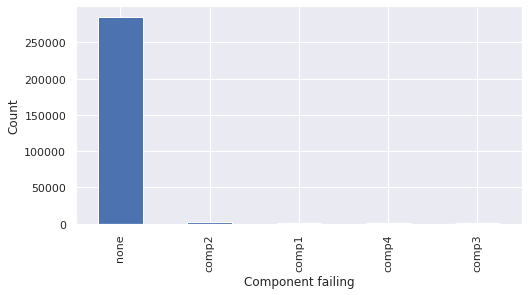

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
final_dataset['failure'].value_counts().plot(kind='bar')
plt.xlabel('Component failing')
plt.ylabel('Count')

From this graph, failure column has five labels i.e. 'none', 'comp1', 'comp2', 'comp3', 'comp4'. 'none' label contains maximum values than other lables.

We can not see proper picture from the histogram. Let's check from Pie graph what it does say about these five labels. So, it visualizes exact percentage of each label.

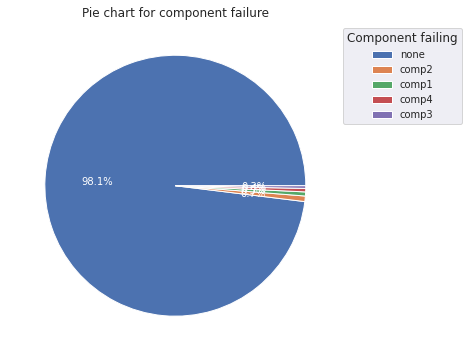

In [ ]:
# prepare the data for plotting
# create a dictionary of classes and their totals
d = final_dataset["failure"].value_counts().to_dict()

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
fig = plt.figure(figsize = (18, 6))
ax = fig.add_subplot()

# ----------------------------------------------------------------------------------------------------
# plot the data using matplotlib
ax.pie(d.values(), # pass the values from our dictionary
       labels = d.keys(), # pass the labels from our dictonary
       autopct = '%1.1f%%', # specify the format to be plotted
       textprops = {'fontsize': 10, 'color' : "white"} # change the font size and the color of the numbers inside the pie
      )
# ----------------------------------------------------------------------------------------------------
# prettify the plot

# set the title
ax.set_title("Pie chart for component failure")

# set the legend and add a title to the legend
ax.legend(loc = "upper left", bbox_to_anchor = (1, 0, 0.5, 1), fontsize = 10, title = "Component failing");

## **4.3) Using SMOTE for imbalance the data**

In predictive maintenance, machine failures are usually rare occurrences in the lifetime of the assets compared to normal operation. This causes an imbalance in the label distribution which usually causes poor performance as algorithms tend to classify majority class examples better at the expense of minority class examples as the total misclassification error is much improved when majority class is labeled correctly. This causes low recall rates although accuracy can be high and becomes a larger problem when the cost of false alarms to the business is very high. To help with this problem, sampling techniques such as oversampling of the minority examples are usually used.

In [ ]:
print("The shape of train data:", x_train_k_best.shape)
print("The shape of train data:",y_train.shape)
print("The shape of test data:",x_test_k_best.shape)
print("The shape of test data:",y_test.shape)
print("The shape of cv data:", x_cv_k_best.shape)
print("The shape of cv data:", y_cv.shape)

The shape of train data: (186457, 5)
The shape of train data: (186457,)
The shape of test data: (58269, 5)
The shape of test data: (58269,)
The shape of cv data: (46615, 5)
The shape of cv data: (46615,)


In [ ]:
print("Before OverSampling, counts of label 'none': {}".format(sum(y_train=='none')))
print("Before OverSampling, counts of label 'comp4': {} \n".format(sum(y_train=='comp4')))
print("Before OverSampling, counts of label 'comp1': {}".format(sum(y_train=='comp1')))
print("Before OverSampling, counts of label 'comp2': {} \n".format(sum(y_train=='comp2')))
print("Before OverSampling, counts of label 'comp3': {}".format(sum(y_train=='comp3')))

Before OverSampling, counts of label 'none': 182837
Before OverSampling, counts of label 'comp4': 794 

Before OverSampling, counts of label 'comp1': 937
Before OverSampling, counts of label 'comp2': 1270 

Before OverSampling, counts of label 'comp3': 619


In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(x_train_k_best, y_train)

In [ ]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label 'none': {}".format(sum(y_train_res=='none')))
print("After OverSampling, counts of label 'comp4': {}".format(sum(y_train_res=='comp4')))
print("After OverSampling, counts of label 'comp1': {}".format(sum(y_train_res=='comp1')))
print("After OverSampling, counts of label 'comp2': {}".format(sum(y_train_res=='comp2')))
print("After OverSampling, counts of label 'comp3': {}".format(sum(y_train_res=='comp3')))

After OverSampling, the shape of train_X: (914185, 5)
After OverSampling, the shape of train_y: (914185,) 

After OverSampling, counts of label 'none': 182837
After OverSampling, counts of label 'comp4': 182837
After OverSampling, counts of label 'comp1': 182837
After OverSampling, counts of label 'comp2': 182837
After OverSampling, counts of label 'comp3': 182837


# **5) Let's model with our data**

## **5.1)Labels that are useful in plotting confusion matrix**

In [ ]:
labels = ['none', 'comp1', 'comp2', 'comp3', 'comp4']

## **5.2) Plot the confusion matrix using helper function**

Confusion Matrix is a tool which helps us to evaluate the performance of our classification model on unseen data. It's a very important tool to evaluate metrics such as Precision, Recall, Accuracy and Area under the ROC curve using these four values - False Positives (FP), False Negatives (FN), True Positives (TP) and True Negatives (TN).

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## **5.3) Generic function To run any specified model using function**

This function is used to evaluate our model on unseen data. We will first obtain the best estimator using either grid search or random search. We will use the best estimator from our model to  generate the classification report for each of our models.

In [ ]:
from datetime import datetime
def perform_model(model, X_train_res, y_train_res, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train_res, y_train_res)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    

    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results

## **5.4) Generic function to print the grid search attributes**

This function will be used to print the best estimator obtained using grid search/random search. For each estimator, we will print the best parameters for a given function along with their best scores on the cross validation dataset.

In [ ]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('--------------------------')
    print('|      Best Estimator     |')
    print('--------------------------')
    print('\n\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('--------------------------')
    print('|     Best parameters     |')
    print('--------------------------')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))


    #  number of cross validation splits
    print('---------------------------------')
    print('|   No of CrossValidation sets   |')
    print('--------------------------------')
    print('\n\tTotal numbre of cross validation sets: {}\n'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('--------------------------')
    print('|        Best Score       |')
    print('--------------------------')
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))

# **6) Machine Learning models**

## **6.1) Logistic regression with grid search**

training the model..
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:  2.6min finished


Done 
 

training_time(HH:MM:SS.ms) - 0:02:56.202071


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.005910


---------------------
|      Accuracy      |
---------------------

    0.9565463625598517


--------------------
| Confusion Matrix |
--------------------

 [[  277     0     0    12     4]
 [   10   387     0     0     0]
 [    2     2   190     0     0]
 [    0     5     6   237     0]
 [ 1276    47   885   283 54646]]


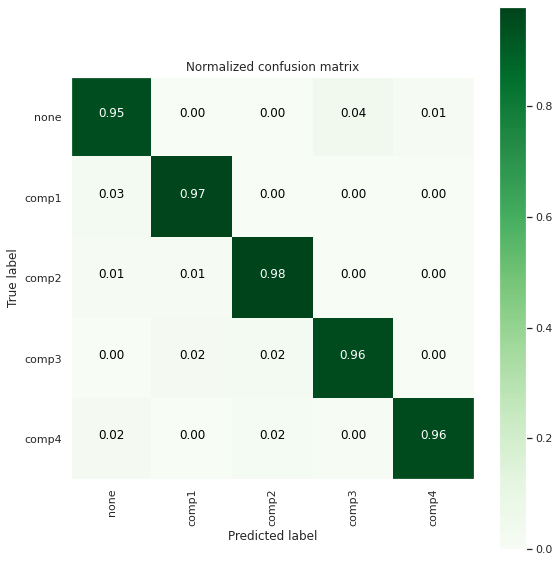

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

       comp1       0.18      0.95      0.30       293
       comp2       0.88      0.97      0.92       397
       comp3       0.18      0.98      0.30       194
       comp4       0.45      0.96      0.61       248
        none       1.00      0.96      0.98     57137

    accuracy                           0.96     58269
   macro avg       0.54      0.96      0.62     58269
weighted avg       0.99      0.96      0.97     58269



In [ ]:
from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
# start Grid search
parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 20], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression(random_state=41, multi_class='ovr')
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=8)
log_reg_grid_results =  perform_model(log_reg_grid, X_train_res, y_train_res, x_test_k_best, y_test, class_labels=labels)

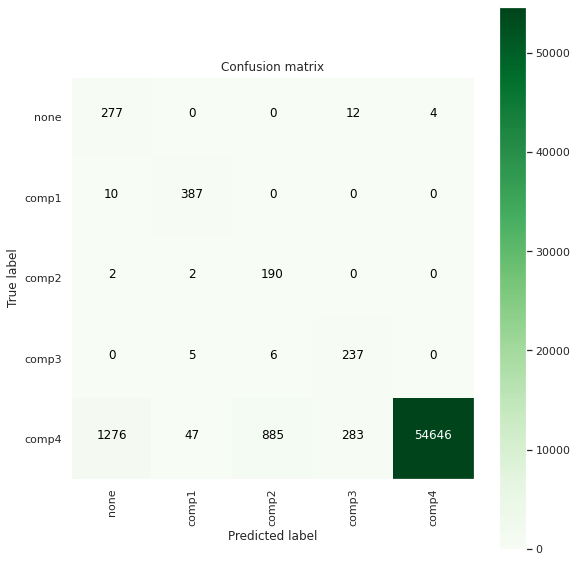

In [ ]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(log_reg_grid_results['confusion_matrix'], classes=labels, cmap=plt.cm.Greens, )
plt.show()

In [ ]:
# observe the attributes of the model 
print_grid_search_attributes(log_reg_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=41, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 20, 'penalty': 'l2'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9722791339510503



## **6.2) Support Vector machines with grid search**

training the model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed: 50.0min finished


Done 
 

training_time(HH:MM:SS.ms) - 0:55:18.289070


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.005215


---------------------
|      Accuracy      |
---------------------

    0.9565463625598517


--------------------
| Confusion Matrix |
--------------------

 [[  277     0     0    12     4]
 [   10   387     0     0     0]
 [    2     2   190     0     0]
 [    0     5     6   237     0]
 [ 1276    47   885   283 54646]]


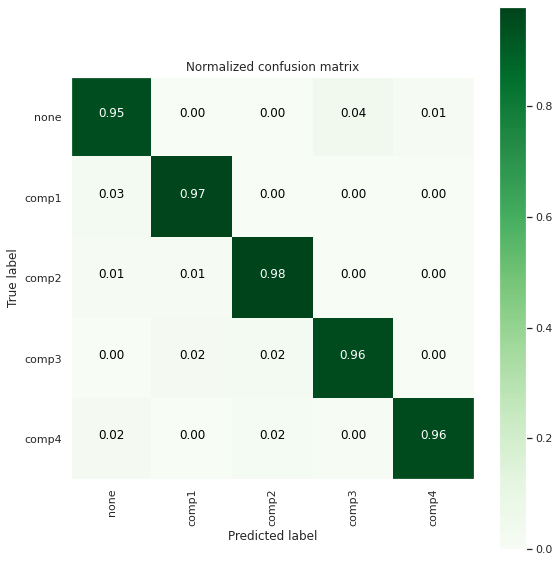

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

       comp1       0.18      0.95      0.30       293
       comp2       0.88      0.97      0.92       397
       comp3       0.18      0.98      0.30       194
       comp4       0.45      0.96      0.61       248
        none       1.00      0.96      0.98     57137

    accuracy                           0.96     58269
   macro avg       0.54      0.96      0.62     58269
weighted avg       0.99      0.96      0.97     58269



In [ ]:
from sklearn.svm import LinearSVC
parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}
lr_svc = LinearSVC(tol=0.00005)
lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters, n_jobs=8, verbose=1)
lr_svc_grid_results = perform_model(lr_svc_grid, X_train_res, y_train_res, x_test_k_best, y_test, class_labels=labels)

In [ ]:
print_grid_search_attributes(lr_svc_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	LinearSVC(C=16, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=5e-05,
          verbose=0)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 16}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9721609958597002



## **6.3) Decision tree classifier with grid search**

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:34.446309


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.004671


---------------------
|      Accuracy      |
---------------------

    0.9570097307316069


--------------------
| Confusion Matrix |
--------------------

 [[  277     0     0    12     4]
 [   10   387     0     0     0]
 [    2     2   190     0     0]
 [    0     5     5   238     0]
 [ 1275    22   885   283 54672]]


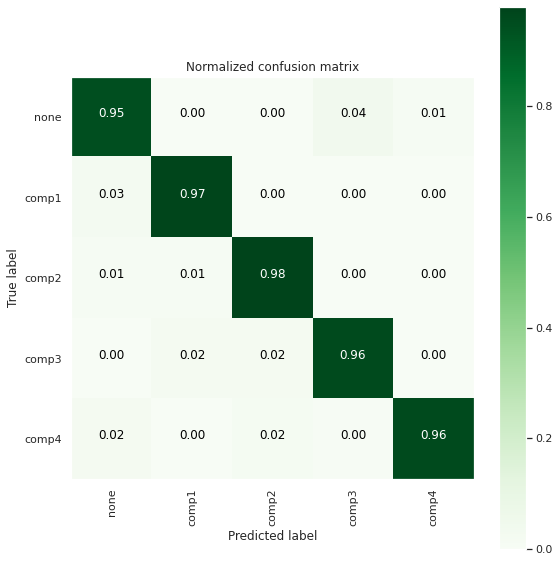

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

       comp1       0.18      0.95      0.30       293
       comp2       0.93      0.97      0.95       397
       comp3       0.18      0.98      0.30       194
       comp4       0.45      0.96      0.61       248
        none       1.00      0.96      0.98     57137

    accuracy                           0.96     58269
   macro avg       0.55      0.96      0.63     58269
weighted avg       0.99      0.96      0.97     58269

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

parameters = {'max_depth':np.arange(3,10,2)}
dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt,param_grid=parameters, n_jobs=8)
dt_grid_results = perform_model(dt_grid, X_train_res, y_train_res, x_test_k_best, y_test, class_labels=labels)
print_grid_search_attributes(dt_grid_results['model'])

## **6.4) Random Forest classifier with grid search**

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:08:12.734108


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.046802


---------------------
|      Accuracy      |
---------------------

    0.9570097307316069


--------------------
| Confusion Matrix |
--------------------

 [[  277     0     0    12     4]
 [   10   387     0     0     0]
 [    2     2   190     0     0]
 [    0     5     5   238     0]
 [ 1275    22   885   283 54672]]


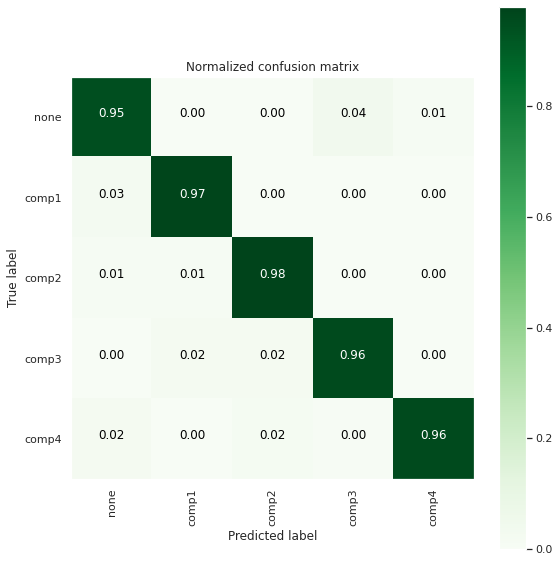

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

       comp1       0.18      0.95      0.30       293
       comp2       0.93      0.97      0.95       397
       comp3       0.18      0.98      0.30       194
       comp4       0.45      0.96      0.61       248
        none       1.00      0.96      0.98     57137

    accuracy                           0.96     58269
   macro avg       0.55      0.96      0.63     58269
weighted avg       0.99      0.96      0.97     58269

--------------------------
|      Best Estimator     |
--------------------------

	RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators': np.arange(10,51,20), 'max_depth':np.arange(3,15,2)}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=8)
rfc_grid_results = perform_model(rfc_grid, X_train_res, y_train_res, x_test_k_best, y_test, class_labels=labels)
print_grid_search_attributes(rfc_grid_results['model'])

# **7) Results**

In [ ]:
print('\n                     Accuracy     Error')
print('                     ----------   --------')
print('Logistic Regression : {:.04}%       {:.04}%'.format(log_reg_grid_results['accuracy'] * 100,\
                                                  100-(log_reg_grid_results['accuracy'] * 100)))

print('Linear SVC          : {:.04}%       {:.04}% '.format(lr_svc_grid_results['accuracy'] * 100,\
                                                        100-(lr_svc_grid_results['accuracy'] * 100)))

print('DecisionTree        : {:.04}%      {:.04}% '.format(dt_grid_results['accuracy'] * 100,\
                                                        100-(dt_grid_results['accuracy'] * 100)))

print('Random Forest       : {:.04}%      {:.04}% '.format(rfc_grid_results['accuracy'] * 100,\
                                                           100-(rfc_grid_results['accuracy'] * 100)))


                     Accuracy     Error
                     ----------   --------
Logistic Regression : 95.65%       4.345%
Linear SVC          : 95.65%       4.345% 
DecisionTree        : 95.7%      4.299% 
Random Forest       : 95.7%      4.299% 


# **8) Summary**

Common data sources for predictive maintenance problems are:

Telemetry: The failure history of a machine or component within the machine.
The first data source is the telemetry time-series data which consists of voltage, rotation, pressure, and vibration measurements collected from 100 machines in real time averaged over every hour collected during the year 2015. Below, we display the first 10 records in the dataset. A summary of the whole dataset is also provided.

Number of data points in the telemetry data (876100, 6).

The attributes of the data points in the telemetry data : ['datetime' 'machineID' 'volt' 'rotate' 'pressure' 'vibration'].

There are no duplicate and unique values in the telemetry dataset. We plotted a pretty standard distribution chart, which is centred around almost exactly 100 and 40 in the histogram of pressure and vibration.

Error: The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.
The second main data source is the error logs. These are incessant errors that occur while the machine is still in operation and are not errors. The date and time of the error are rounded to the nearest hour, since telemetry data is collected every hour.
Number of data points in the errors data (3919, 3).
The attributes of the data points in the errors data : ['datetime' 'machineID' 'errorID'].
There are no duplicate and unique values in the error dataset.

Maintenance: These are scheduled and unscheduled maintenance records that correspond to both regular component inspections and errors. A log is generated if a component is replaced during the scheduled inspection or is replaced due to an error. Records created due to errors are referred to as errors, which are explained in the following sections. The maintenance data contain records from 2014 and 2015.
Number of data points in the maintenance data (3286, 3).
The attributes of the data points in the maintenance data : ['datetime' 'machineID' 'comp'].
There are no duplicate, unique and missing values in the maintenance data.

Machine features: The features of a machine, e.g. engine size, make and model, location.
This data set includes some information about the machines: model type and age (years in service).
Number of data points in the machines data (100, 3).
The attributes of the data points in the machines data : ['machineID' 'model' 'age'].
There are no duplicate, unique and missing values in the machine dataset. 

Failures: These are the records of component replacements due to failures. Each record has a date and time, machine ID, and failed component type.
Number of data points in the failures data (761, 3)
The attributes of the data points in the failures data : ['datetime' 'machineID' 'failure'].
There are no duplicate, unique and missing values in the failure dataset.

The first step in predictive maintenance applications is feature engineering which requires bringing the different data sources together to create features that best describe a machines's health condition at a given point in time. In the next sections, several feature engineering methods are used to create features based on the properties of each data source.
We selected the size of a window and calculate the aggregate measurements (mean, standard deviation, minimum, maximum, etc.) to represent the short-term history.

Next, we calculated the moving average and standard deviation of the telemetry data in the last 3 hour and 24 hour delay window.

Like telemetry data, errors come with timestamps. An important difference is that the error IDs are categorical values and should not be averaged over time intervals like the telemetry measurements. Instead, we count the number of errors of each type in a lagging window. We begin by reformatting the error data to have one entry per machine per time at which at least one error occurred.

A crucial data set in this example is the maintenance records which contain the information of component replacement records. Possible features from this data set can be, for example, the number of replacements of each component in the last 3 months to incorporate the frequency of replacements. However, more relevent information would be to calculate how long it has been since a component is last replaced as that would be expected to correlate better with component failures since the longer a component is used, the more degradation should be expected. In the following, the days since last component replacement are calculated for each component type as features from the maintenance data.

The machine features can be used without further modification. These include descriptive information about the type of each machine and its age (number of years in service). If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

Lastly, we merge all the feature data sets we created earlier to get the final feature matrix.

When we are using multi-class classification for predicting failure due to a problem, labelling is done by taking a time window prior to the failure of an asset and labelling the feature records that fall into that window as "about to fail due to a problem". The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4).

We saved the final dataset which is created after combining all like telemerty, error, maintenance, machines and failures in one csv file. On the basis of these file, we proceed further for model evaluation. 
There are number of data points in final_dataset :  291341.
There are number of features in final_dataset:  33.

We divide the records into large parts into training, validation and test sets to minimize the number of time intervals shared between them.

To help with imbalance problem, we use Synthetic minority over-sampling techniques (SMOTE) used.

We performed machine learning models on the dataset by using helper function for confusion matrix, model and gridsearch attributes. We found decision tree and random forest classifier perform very well rather than logistic regression and SVM. 
 We have done feature extraction by using Univariate analysis method on the most important features. All machine learning models such as Logistic Regression, SVM, Decision tree and Random forest are giving the accuracy almost about 95%-96% if we do the feature extraction.
